# Unet

In [12]:
#pip install io

## pre_proc

In [13]:
import torch
import os
def tensor2img(x):
    img = (x[:,0,:,:]>x[:,1,:,:]).float()
    img = img*255
    return img

def to_data( x):
    """Convert variable to tensor."""
    if torch.cuda.is_available():
        x = x.cpu()
    return x.data

# def update_lr(self, g_lr, d_lr):
#     for param_group in self.optimizer.param_groups:
#         param_group['lr'] = lr

def reset_grad(self):
    """Zero the gradient buffers."""
    self.unet.zero_grad()

def compute_accuracy(self,SR,GT):
    SR_flat = SR.view(-1)
    GT_flat = GT.view(-1)

    acc = GT_flat.data.cpu()==(SR_flat.data.cpu()>0.5)

def print_network(model, name):
    """Print out the network information."""
    num_params = 0
    for p in model.parameters():
        num_params += p.numel()
    #print(model)
    print(name)
    print("The number of parameters: {}".format(num_params))

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)



class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1): # n luôn bằng 1 
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count # loss trung bình trên 1 batchsize

## scheduler


In [14]:
import os
import datetime
import torch
import json
import wandb
import tqdm
import numpy as np
import math
import random
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmupRestarts(_LRScheduler):
    """
        optimizer (Optimizer): Wrapped optimizer.
        first_cycle_steps (int): First cycle step size.
        cycle_mult(float): Cycle steps magnification. Default: -1.
        max_lr(float): First cycle's max learning rate. Default: 0.1.
        min_lr(float): Min learning rate. Default: 0.001.
        warmup_steps(int): Linear warmup step size. Default: 0.
        gamma(float): Decrease rate of max learning rate by cycle. Default: 1.
        last_epoch (int): The index of last epoch. Default: -1.
    """
    
    def __init__(self,
                 optimizer : torch.optim.Optimizer,
                 first_cycle_steps : int,
                 cycle_mult : float = 1.,
                 max_lr : float = 0.1,
                 min_lr : float = 0.001,
                 warmup_steps : int = 0,
                 gamma : float = 1.,
                 last_epoch : int = -1
        ):
        assert warmup_steps < first_cycle_steps
        
        self.first_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle_mult = cycle_mult # cycle steps magnification
        self.base_max_lr = max_lr # first max learning rate
        self.max_lr = max_lr # max learning rate in the current cycle
        self.min_lr = min_lr # min learning rate
        self.warmup_steps = warmup_steps # warmup step size
        self.gamma = gamma # decrease rate of max learning rate by cycle
        
        self.cur_cycle_steps = first_cycle_steps # first cycle step size
        self.cycle = 0 # cycle count
        self.step_in_cycle = last_epoch # step size of the current cycle
        
        super(CosineAnnealingWarmupRestarts, self).__init__(optimizer, last_epoch)
        
        # set learning rate min_lr
        self.init_lr()
    
    def init_lr(self):
        self.base_lrs = []
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.min_lr
            self.base_lrs.append(self.min_lr)
    
    def get_lr(self):
        if self.step_in_cycle == -1:
            return self.base_lrs
        elif self.step_in_cycle < self.warmup_steps:
            return [(self.max_lr - base_lr)*self.step_in_cycle / self.warmup_steps + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.max_lr - base_lr) \
                    * (1 + math.cos(math.pi * (self.step_in_cycle-self.warmup_steps) \
                                    / (self.cur_cycle_steps - self.warmup_steps))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.step_in_cycle = self.step_in_cycle + 1
            if self.step_in_cycle >= self.cur_cycle_steps:
                self.cycle += 1
                self.step_in_cycle = self.step_in_cycle - self.cur_cycle_steps
                self.cur_cycle_steps = int((self.cur_cycle_steps - self.warmup_steps) * self.cycle_mult) + self.warmup_steps
        else:
            if epoch >= self.first_cycle_steps:
                if self.cycle_mult == 1.:
                    self.step_in_cycle = epoch % self.first_cycle_steps
                    self.cycle = epoch // self.first_cycle_steps
                else:
                    n = int(math.log((epoch / self.first_cycle_steps * (self.cycle_mult - 1) + 1), self.cycle_mult))
                    self.cycle = n
                    self.step_in_cycle = epoch - int(self.first_cycle_steps * (self.cycle_mult ** n - 1) / (self.cycle_mult - 1))
                    self.cur_cycle_steps = self.first_cycle_steps * self.cycle_mult ** (n)
            else:
                self.cur_cycle_steps = self.first_cycle_steps
                self.step_in_cycle = epoch
                
        self.max_lr = self.base_max_lr * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

## util

In [15]:
import os
import datetime
import torch
import json
import wandb
import tqdm
import numpy as np
import math
import random
import cv2
import matplotlib.pyplot as plt
import torch.backends.cudnn


def save_model(path, step, model, optimizer, scheduler, best_unet_score):
    torch.save({
        'step': step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_unet_score': best_unet_score,
    }, path)



def load_model(model, optimizer, scheduler, resume, device):
    checkpoint = torch.load(resume, map_location=device)
    print('loaded weights from {}, step {}, best_unet_score {}'.format(
        resume, checkpoint['step'], checkpoint['best_unet_score']))

    model.load_state_dict(checkpoint['model_state_dict'])

    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    step = checkpoint['step']
    best_unet_score = checkpoint['best_unet_score']

    return model, optimizer, scheduler, step, best_unet_score



def predict_plt(model, dataset):
    model.eval()
    #pbar = tqdm(total=8, desc="Predict")
    imgs = []
    masks = []
    mask_preds = []
    bi_mask_preds = []

    with torch.no_grad():
        for i in range(0, 8):
            device = 'cuda' if next(model.parameters()).is_cuda else 'cpu'
            
            index = np.random.choice(len(dataset)) 

            #img, mask, img_path,mask_path = dataset[index]
            img, mask = dataset[index]

            img = img.to(device)

            mask = mask.to(device)

            img = torch.unsqueeze(img,0) # mở dimen batchsize
            mask_pre = torch.sigmoid(model(img))   
            

            imgs.append(img) 
            masks.append(mask) 
            mask_preds.append(mask_pre)
            bi_mask_preds.append(mask_pre)

            

        figure, ax = plt.subplots(nrows=8, ncols=4, figsize=(15, 10))
        for i in range(8):


#=============img   
            img = (imgs[i] * 0.5 + 0.5).cpu().numpy()
#Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers
            img = np.squeeze(img, axis=0)  
            img = img.transpose((1, 2, 0))
    

#=============mask 
            mask = masks[i] 
            mask =mask.cpu().numpy() 
            mask = mask.transpose((1, 2, 0))
            

#=============== mask predict
            mask_pre = mask_preds[i].cpu().numpy() 
            mask_pre = np.squeeze(mask_pre,0) 
            mask_pre = mask_pre.transpose((1, 2, 0))
            

#=============== binary mask
            bi_mask_pre = bi_mask_preds[i].cpu().numpy()
            bi_mask_pre = np.squeeze(bi_mask_pre,0) 
            bi_mask_pre = bi_mask_pre.transpose((1, 2, 0))
            ret,bi_mask_pre = cv2.threshold(bi_mask_pre,0.5,1,cv2.THRESH_BINARY) 
            
#============== matplotlib show
            ax[i, 0].imshow(img,interpolation="nearest")
            ax[i, 0].set_title("Image")
            ax[i, 0].set_axis_off()

            ax[i, 1].imshow(mask,interpolation="nearest", cmap='gray')
            ax[i, 1].set_title("Mask")
            ax[i, 1].set_axis_off()

            ax[i, 2].imshow(mask_pre,interpolation="nearest", cmap= 'jet')#'jet'
            ax[i, 2].set_title("Mask_Pre")
            ax[i, 2].set_axis_off()
            
            ax[i, 3].imshow(bi_mask_pre,interpolation="nearest", cmap='gray')
            ax[i, 3].set_title("Bi Mask Pre")
            ax[i, 3].set_axis_off()


        plt.show()



def predict_cv2(model,model_type ,dataset,cfg,overlay = False):
    model.eval()
   

    with torch.no_grad():
        
        for i in range(len(dataset)):  #8
            device = 'cuda' if next(model.parameters()).is_cuda else 'cpu'
            
            #index = np.random.choice(len(dataset)) 

            img, mask = dataset[i]
    
            img = torch.unsqueeze(img,0)
            img = img.to(device)
            mask = mask.to(device)
            mask_pre = torch.sigmoid(model(img))

            bi_mask_pre = mask_pre



#============== img
# <class 'torch.Tensor'> \ torch.Size([1, 3, 224, 224])
            img = (img * 0.5 + 0.5).numpy()# (1, 3, 224, 224)  \ <class 'numpy.ndarray'> 
            img = np.squeeze(img, axis=0) # bỏ dimension batchsize
            img = img.transpose((1, 2, 0))
#======================cv2
            img = img*255
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)



#============== mask
# <class 'torch.Tensor'> \ torch.Size([1, 224, 224])
            mask =mask.numpy() 
            mask = mask.transpose((1, 2, 0)) #  (224, 224,1)  \ <class 'numpy.ndarray'>

#======================cv2
            mask = mask*255 # tại sao GT của mask lại cần phải nhân 255 ta , ban đầu đâu cần
            mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) # (224, 224,3)


#============== mask_pre
            mask_pre = mask_pre.numpy()# (1, 1, 224, 224) \ <class 'numpy.ndarray'>
            mask_pre = np.squeeze(mask_pre,0) # <class 'numpy.ndarray'> \ (1, 224, 224)
            mask_pre = mask_pre.transpose((1, 2, 0)) # (224, 224,1)
#======================cv2
            mask_pre = mask_pre*255 # đưa về 0;255  
            mask_pre = np.uint8(mask_pre) # đưa về uint để chuyển sang bản đồ JET
            mask_pre = cv2.applyColorMap(mask_pre, cv2.COLORMAP_JET)

            #if overlay:
            img = img.astype(mask_pre.dtype)
            overlay = cv2.addWeighted(img, 0.4, mask_pre, 0.4, 5)#, dtype=mask_pre.dtype
            

# ================ binary_mask

            bi_mask_pre = bi_mask_pre.numpy()# (1, 1, 224, 224) \ <class 'numpy.ndarray'>
            bi_mask_pre = np.squeeze(bi_mask_pre,0) # <class 'numpy.ndarray'> \ (1, 224, 224)
            bi_mask_pre = bi_mask_pre.transpose((1, 2, 0))# <class 'numpy.ndarray'> \ ( 224, 224, 1)
            bi_mask_pre = bi_mask_pre*255
            ret,bi_mask_pre = cv2.threshold(bi_mask_pre,127,255,cv2.THRESH_BINARY) 
            bi_mask_pre = cv2.cvtColor(bi_mask_pre, cv2.COLOR_GRAY2RGB) # cv2


            # =============contour ground truth img
        
            contours,_ = cv2.findContours(
            np.uint8(cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )
            contour_GT_img = cv2.drawContours(img.copy(), contours, -1, color=(0, 23, 223), thickness=0)

            #============contour predict img

            contours,_ = cv2.findContours(
            np.uint8(cv2.cvtColor(bi_mask_pre, cv2.COLOR_RGB2GRAY)), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
            )
            contour_pre_img = cv2.drawContours(img.copy(), contours, -1, color=(0, 255, 0), thickness=0)


            hang1 = np.hstack(
            [
                contour_GT_img,
                mask
            ])

            hang2 = np.hstack(
            [
                overlay,
                mask_pre
            ])

            hang3 = np.hstack(
            [
                contour_pre_img,
                bi_mask_pre
            ])


            vis_result = np.vstack(
            [
                hang1,
                hang2,
                hang3
            ])

            name = cfg['RESULT']['savedir'] + '/' + model_type + '-ISCS2018' + '/q' +str(i) + '.png'
            print(name)
            cv2.imwrite(name,vis_result)
        
        
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
class AverageMeter:
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count # loss trung bình trên 1 batchsize


## evaluation

In [16]:
import os
import datetime
import torch
import json
import wandb
import tqdm
import numpy as np
import math
import random
import matplotlib.pyplot as plt

# SR : Segmentation Result
# GT : Ground Truth

def get_accuracy(SR,GT,threshold=0.5):
    SR = SR > threshold
    GT = GT == torch.max(GT)
    corr = torch.sum(SR==GT)
    tensor_size = SR.size(0)*SR.size(1)*SR.size(2)*SR.size(3)
    acc = float(corr)/float(tensor_size)

    return acc

def get_sensitivity(SR,GT,threshold=0.5):
    # Sensitivity == Recall
    SR = SR > threshold
    GT = GT == torch.max(GT)

    # TP : True Positive
    # FN : False Negative
    TP = ((SR==1).byte()+(GT==1).byte())==2
    FN = ((SR==0).byte()+(GT==1).byte())==2

    SE = float(torch.sum(TP))/(float(torch.sum(TP+FN)) + 1e-6)     
    
    return SE

def get_specificity(SR,GT,threshold=0.5):
    SR = SR > threshold
    GT = GT == torch.max(GT)

    # TN : True Negative
    # FP : False Positive
    TN = ((SR==0).byte()+(GT==0).byte())==2
    FP = ((SR==1).byte()+(GT==0).byte())==2

    SP = float(torch.sum(TN))/(float(torch.sum(TN+FP)) + 1e-6)
    
    return SP

def get_precision(SR,GT,threshold=0.5):
    SR = SR > threshold
    GT = GT == torch.max(GT)

    # TP : True Positive
    # FP : False Positive
    TP = ((SR==1).byte()+(GT==1).byte())==2
    FP = ((SR==1).byte()+(GT==0).byte())==2

    PC = float(torch.sum(TP))/(float(torch.sum(TP+FP)) + 1e-6)

    return PC

def get_F1(SR,GT,threshold=0.5):
    # Sensitivity == Recall
    SE = get_sensitivity(SR,GT,threshold=threshold)
    PC = get_precision(SR,GT,threshold=threshold)

    F1 = 2*SE*PC/(SE+PC + 1e-6)

    return F1

def get_JS(SR,GT,threshold=0.5):
    # JS : Jaccard similarity
    SR = SR > threshold
    GT = GT == torch.max(GT)
    
    Inter = torch.sum((SR.byte()+GT.byte())==2)
    Union = torch.sum((SR.byte()+GT.byte())>=1)
    
    JS = float(Inter)/(float(Union) + 1e-6)
    
    return JS

def get_DC(SR,GT,threshold=0.5):
    # DC : Dice Coefficient
    SR = SR > threshold
    GT = GT == torch.max(GT)

    Inter = torch.sum((SR.byte()+GT.byte())==2)
    DC = float(2*Inter)/(float(torch.sum(SR)+torch.sum(GT)) + 1e-6)

    return DC





## data loader

In [17]:
import os
import datetime
import torch
import json
import wandb
import tqdm
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from random import shuffle
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms as T
from torchvision.transforms import functional as F
from PIL import Image
import matplotlib.pyplot as plt


class ImageFolder(Dataset):
	def __init__(self, root,image_size=224,mode='train',augmentation_prob=0.4):
		"""Initializes image paths and preprocessing module."""
		self.root = root

		
		if mode == 'train':	
			self.root = self.root + '/train/' + 'ISIC2018_Task1_Training_Input/'
		elif mode == 'valid':
			self.root = self.root + '/valid/' + 'ISIC2018_Task1_Validation_Input/'
		elif mode == 'test':
			self.root = self.root + '/test/' + 'ISIC2018_Task1_Test_Input/'
		#print(self.root)			
		#print(self.root[:-7])
		# GT : Ground Truth
		self.GT_paths = self.root[:-7]+'_GroundTruth/' # tên folder groundtruth ( chưa phải là list các file con bên trong folder GT như biến self.image_paths bên dưới ) 
		#print(self.GT_paths)
		self.image_paths = list(map(lambda x: os.path.join(self.root, x), os.listdir(self.root))) # tạo ra list chưa các file con là đường dẫn (dir) của folder root

		self.image_size = image_size # không xài
		self.mode = mode
		self.RotationDegree = [0,90,180,270]
		self.augmentation_prob = augmentation_prob
		print("image count in {} path :{}".format(self.mode,len(self.image_paths)))

	def __getitem__(self, index):
		"""Reads an image from a file and preprocesses it and returns."""
		image_path = self.image_paths[index]
		filename = image_path.split('_')[-1][:-len(".jpg")]
		GT_path = self.GT_paths + 'ISIC_' + filename + '_segmentation.png'
		# print(image_path)
		# print(GT_path)
		image = Image.open(image_path)
		if image is None:
			print('Corrupted image for %d' % image_path)
		
		GT = Image.open(GT_path)
		if GT is None:
			print('Corrupted image for %d' % GT_path)
		
		aspect_ratio = image.size[1]/image.size[0]

		Transform = []

		ResizeRange = random.randint(300,320)    # 300 #
		Transform.append(T.Resize((int(ResizeRange*aspect_ratio),ResizeRange)))
		p_transform = random.random()

		if (self.mode == 'train') and p_transform <= self.augmentation_prob:
			RotationDegree = random.randint(0,3)
			RotationDegree = self.RotationDegree[RotationDegree]
			if (RotationDegree == 90) or (RotationDegree == 270):
				aspect_ratio = 1/aspect_ratio

			Transform.append(T.RandomRotation((RotationDegree,RotationDegree)))
						
			RotationRange = random.randint(-10,10)
			Transform.append(T.RandomRotation((RotationRange,RotationRange)))
			CropRange = random.randint(250,270)
			Transform.append(T.CenterCrop((int(CropRange*aspect_ratio),CropRange)))
			Transform = T.Compose(Transform)
			
			image = Transform(image)
			GT = Transform(GT)

			ShiftRange_left = random.randint(0,20)
			ShiftRange_upper = random.randint(0,20)
			ShiftRange_right = image.size[0] - random.randint(0,20)
			ShiftRange_lower = image.size[1] - random.randint(0,20)
			image = image.crop(box=(ShiftRange_left,ShiftRange_upper,ShiftRange_right,ShiftRange_lower))
			GT = GT.crop(box=(ShiftRange_left,ShiftRange_upper,ShiftRange_right,ShiftRange_lower))

			if random.random() < 0.5:
				image = F.hflip(image)
				GT = F.hflip(GT)

			if random.random() < 0.5:
				image = F.vflip(image)
				GT = F.vflip(GT)

			Transform = T.ColorJitter(brightness=0.2,contrast=0.2,hue=0.02)

			image = Transform(image)

			Transform =[]


		Transform.append(T.Resize((256,256)))


		Transform.append(T.ToTensor())
		Transform = T.Compose(Transform)
		
		image = Transform(image)
		GT = Transform(GT)

		Norm_ = T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
		image = Norm_(image)
		#print(f'{image.shape}      {GT.shape}')
		return image, GT
		# if self.mode == 'train' or self.mode == 'valid':
		# 	return image, GT
		# else:
		# 	return image, GT,image_path,GT_path



	def __len__(self):
		"""Returns the total number of font files."""
		return len(self.image_paths)



# def my_collate(batch):
#     image = [item[0] for item in batch]
#     mask = [item[1] for item in batch]
#     image = torch.stack(image, 0)
#     mask = torch.cat(mask, 0)
#     return image, mask


def get_loader(image_path, image_size, batch_size, num_workers=0, mode='train',augmentation_prob=0.4):
	"""Builds and returns Dataloader."""
	
	dataset = ImageFolder(root = image_path, image_size =image_size, mode=mode,augmentation_prob=augmentation_prob)
	
	if mode == 'train':
		print('Visualize augmentations...')	
		visualize_augmentations(dataset, samples=3)
	if mode == 'train' or mode == 'valid':
		data_loader = DataLoader(dataset=dataset,
									batch_size=batch_size,
									shuffle=True,
									num_workers=num_workers)
		print('123')
		return data_loader
	else: # mode = test thì chỉ return dataset để có thể trỏ vào từng ảnh để sử dụng hàm predict
		print('321')
		return dataset


def visualize_augmentations(dataset, samples=3):
        n = np.arange(0, len(dataset))
        figure, ax = plt.subplots(nrows=samples, ncols=2, figsize=(15, 10))
        for i in range(samples):
            image, mask = dataset[np.random.choice(n)]
            denormalized_image = (image * 0.5 + 0.5)
            ax[i, 0].imshow(denormalized_image.numpy().transpose(1, 2, 0),
                            interpolation="nearest", cmap='gray')
            ax[i, 0].set_title("Image")
            ax[i, 0].set_axis_off()
            ax[i, 1].imshow(mask.numpy().transpose(1, 2, 0),
                            interpolation="nearest", cmap='gray')
            ax[i, 1].set_title("Mask")
            ax[i, 1].set_axis_off()
            

        plt.tight_layout()
        plt.show()

## network

In [18]:
import torch
import torch.nn as nn
from torch.nn import init

def init_weights(modules):
    for m in modules:
        if isinstance(m, nn.Conv2d):
            init.xavier_uniform_(m.weight.data)
            if m.bias is not None:
                m.bias.data.zero_()
        elif isinstance(m, nn.BatchNorm2d):
            m.weight.data.fill_(1)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.01)
            m.bias.data.zero_()

    
    
class conv_block(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(conv_block,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.BatchNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )
        #init_weights(self.conv.modules())

    def forward(self,x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )
        #init_weights(self.up.modules())
        
    def forward(self,x):
        x = self.up(x)
        return x

class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )
        #init_weights(self.conv.modules())
    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1
        
class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t), # cái này khởi tạo ở khối Recurrent_block rồi nên khỏi phải khởi tạo nữa
            #Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)
        #init_weights(self.Conv_1x1.modules())
    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1



class U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)
        
        #init_weights(self.Conv_1x1.modules())
       
        
    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        
        d5 = self.Up_conv5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


class R2U_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1,t=2):
        super(R2U_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)
        #init_weights(self.Conv_1x1.modules())

    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4,d5),dim=1)
        d5 = self.Up_RRCNN5(d5)
        
        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


class attention_gate(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.Wg = nn.Sequential(
            nn.Conv2d(in_c[0], out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.Wx = nn.Sequential(
            nn.Conv2d(in_c[1], out_c, kernel_size=1, padding=0),
            nn.BatchNorm2d(out_c)
        )
        self.relu = nn.ReLU(inplace=True)
        self.output = nn.Sequential(
            nn.Conv2d(out_c, 1, kernel_size=1, padding=0),
            nn.Sigmoid()
        )
        
#         init_weights(self.Wg.modules())
#         init_weights(self.Wx.modules())
#         init_weights(self.output.modules())
        
    def forward(self, g, x):
        Wg = self.Wg(g)
        Wx = self.Wx(x)
        out = self.relu(Wg + Wx)
        out = self.output(out)
        return out * x
    
    

class AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Att5 = attention_gate([1024,512],512)
        self.c5 = conv_block(ch_in=1024+512, ch_out=512)

       
        self.Att4 = attention_gate([512,256],256)
        self.c4 = conv_block(ch_in=512+256, ch_out=256)
        
    
        self.Att3 = attention_gate([256,128],128)
        self.c3 = conv_block(ch_in=256+128, ch_out=128)
        
       
        self.Att2 = attention_gate([128,64],64)
        self.c2 = conv_block(ch_in=128+64, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)
#         init_weights(self.Conv_1x1.modules())
    
    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)
        
        # decoding + concat path
        d5 = self.up(x5) # d5 là gating , x4 là skip connection
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((d5,x4),dim=1)        
        d5 = self.c5(d5)
        
        d4 = self.up(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((d4,x3),dim=1)
        d4 = self.c4(d4)

        d3 = self.up(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((d3,x2),dim=1)
        d3 = self.c3(d3)

        d2 = self.up(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((d2,x1),dim=1)
        d2 = self.c2(d2)

        d1 = self.Conv_1x1(d2)

        return d1


class R2AttU_Net(nn.Module):
    def __init__(self,img_ch=3,output_ch=1,t=2):
        super(R2AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.RRConv1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)
        self.RRConv2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        self.RRConv3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        self.RRConv4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        self.RRConv5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)

        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.Att5 = attention_gate([1024,512],512)
        self.RRc5 = RRCNN_block(ch_in=1024+512, ch_out=512,t=t)

       
        self.Att4 = attention_gate([512,256],256)
        self.RRc4 = RRCNN_block(ch_in=512+256, ch_out=256,t=t)
        
    
        self.Att3 = attention_gate([256,128],128)
        self.RRc3 = RRCNN_block(ch_in=256+128, ch_out=128,t=t)
        
       
        self.Att2 = attention_gate([128,64],64)
        self.RRc2 = RRCNN_block(ch_in=128+64, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)
#         init_weights(self.Conv_1x1.modules())

    def forward(self,x):
        # encoding path
        x1 = self.RRConv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRConv2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRConv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRConv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRConv5(x5)
        
        # decoding + concat path
        d5 = self.up(x5) # d5 là gating , x4 là skip connection
        x4 = self.Att5(g=d5,x=x4)
        d5 = torch.cat((d5,x4),dim=1)        
        d5 = self.RRc5(d5)
        
        d4 = self.up(d5)
        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((d4,x3),dim=1)
        d4 = self.RRc4(d4)

        d3 = self.up(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((d3,x2),dim=1)
        d3 = self.RRc3(d3)

        d2 = self.up(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((d2,x1),dim=1)
        d2 = self.RRc2(d2)

        d1 = self.Conv_1x1(d2)

        return d1    
# if __name__ == "__main__":
#     x = torch.randn((2, 3, 512, 512)) # nó sử dụng hàm ReLu nên coi cẩn thận có nên clipping gradient khg
#     #print(x)
#     model = R2AttU_Net()
#     output = model(x)
#     print(output.shape)
#     model = U_Net()
#     output = model(x)
#     print(output.shape)
#     model = R2U_Net()
#     output = model(x)
#     print(output.shape)
#     model = AttU_Net()
#     output = model(x)
#     print(output.shape)

In [19]:
# !pip install torchmetrics
# !pip install segmentation_models_pytorch
# !pip install albumentations
# !pip install timm

In [20]:
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader
# import torchmetrics
# import segmentation_models_pytorch as smp
# import albumentations as A
# from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
# import os
# from tqdm import tqdm
# from glob import glob
# import timm


# #model UNet
# def unet_block(in_channels, out_channels):
#     return nn.Sequential(
#         nn.Conv2d(in_channels, out_channels, 3, 1, 1),
#         nn.ReLU(),
#         nn.Conv2d(out_channels, out_channels, 3, 1, 1),
#         nn.ReLU()
#     )

# class ResUnet(nn.Module):
#     def __init__(self, n_classes):
#         super().__init__()
#         self.n_classes = n_classes
#         self.backbone = timm.create_model("resnet50", pretrained=True, features_only=True)
#         self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
#         self.block_neck = unet_block(512, 1024)
#         self.block_up1 = unet_block(1024+512, 512)
#         self.block_up2 = unet_block(512+256, 256)
#         self.block_up3 = unet_block(256+128, 128)
#         self.block_up4 = unet_block(128+64, 64)
#         self.conv_cls = nn.Conv2d(64, self.n_classes, 1)

#     def forward(self, x):
#         x1, x2, x3, x4, x5 = self.backbone(x)
#         #x1 (B, 64, 128, 128) size/2
#         #x2 (B, 256, 64, 64) size/4
#         #x3 (B, 512, 32, 32) size/16
#         #x4 (B, 1024, 16, 16) size/32
#         #x5 (B, 2048, 8, 8) size/64
#         d = self.block_neck(x4) # x (B, 1024, 8, 8)
#         x # (1024,32,32)
# #         print(x4.shape)
# #         print(self.upsample(x).shape)

#         d = torch.cat([x2, self.upsample(d)], dim=1)
#         x = self.block_up1(x)
#         x = torch.cat([x2, self.upsample(x)], dim=1)
#         x = self.block_up2(x)
#         x = torch.cat([x1, self.upsample(x)], dim=1)
#         x = self.block_up3(x)
#         x = torch.cat([x1, self.upsample(x)], dim=1)
#         x = self.block_up4(x)
#         x = self.conv_cls(x) #size/2
#         #x = self.upsample(x)
#         return x

# if __name__ == "__main__":
#     x = torch.randn((2, 3, 512, 512)) # nó sử dụng hàm ReLu nên coi cẩn thận có nên clipping gradient khg
#     backbone = timm.create_model("resnet50",pretrained = True, features_only = True)
#     features = backbone(x)
#     for feature in features:
#         print(feature.shape)
#     model = ResUnet(n_classes = 1 )
#     output = model(x)
#     print(output.shape)


In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob
from torchvision.datasets import VOCSegmentation
import timm


#model UNet
def unet_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, 1, 1),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1),
        nn.ReLU()
    )

class ResUnet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.backbone = timm.create_model("resnet50", pretrained=True, features_only=True)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        self.block_neck = unet_block(2048, 1024)
        self.block_up1 = unet_block(1024+1024, 512)
        self.block_up2 = unet_block(512+512, 256)
        self.block_up3 = unet_block(256+256, 128)
        self.block_up4 = unet_block(128+64, 64)
        self.conv_cls = nn.Conv2d(64, self.n_classes, 1)

    def forward(self, x):
        x1, x2, x3, x4, x5 = self.backbone(x) # xchannel = 3 ,256,256
        #x1 (B, 64, 128, 128) size/2
        #x2 (B, 256, 64, 64) size/4
        #x3 (B, 512, 32, 32) size/16
        #x4 (B, 1024, 16, 16) size/32
        #x5 (B, 2048, 8, 8) size/64
        x = self.block_neck(x5) # x (B, 1024, 8, 8)
        x = torch.cat([x4, self.upsample(x)], dim=1)
        x = self.block_up1(x)
        x = torch.cat([x3, self.upsample(x)], dim=1)
        x = self.block_up2(x)
        x = torch.cat([x2, self.upsample(x)], dim=1)
        x = self.block_up3(x)
        x = torch.cat([x1, self.upsample(x)], dim=1)
        x = self.block_up4(x)
        x = self.conv_cls(x) #size/2
        x = self.upsample(x)
        return x
    
 # v2 khong co blockneck
class Res18Unetv1(nn.Module): # v1 co block neck
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.backbone = timm.create_model("resnet18", pretrained=True, features_only=True)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        self.block_neck = unet_block(512, 1024) # 16,16,512 --> 16,16,1024
        self.block_up1 = unet_block(1024+256, 256) #1024 + 256 
        self.block_up2 = unet_block(256+128, 128)
        self.block_up3 = unet_block(128+64, 64)
        self.block_up4 = unet_block(64+64, 64)
        self.conv_cls = nn.Conv2d(64, self.n_classes, 1)
# neu build unet tu dau , thi x1 se bang 64,size,size
# neu build unet theo backbone resnet thi x1 se bang 64,size/2,size/2 ( nghia la sau lop maxpooling)
# vay nen nho upsample o cuoi cung khi build unet backbone resnet
    def forward(self, x):
        x1, x2, x3, x4, x5 = self.backbone(x) # x = bs,3,512,512 
        #x1 [2, 64, 256, 256] size/2
        #x2 [2, 64, 128, 128] size/4
        #x3 [2, 128, 64, 64] size/16
        #x4 [2, 256, 32, 32] size/32
        #x5 [2, 512, 16, 16] size/64
        x = self.block_neck(x5)# 16,16,1024
        x = torch.cat([x4, self.upsample(x)], dim=1)
        x = self.block_up1(x)
        x = torch.cat([x3, self.upsample(x)], dim=1)
        x = self.block_up2(x)
        x = torch.cat([x2, self.upsample(x)], dim=1)
        x = self.block_up3(x)
        x = torch.cat([x1, self.upsample(x)], dim=1)
        x = self.block_up4(x)
        x = self.conv_cls(x) #size/2
        x = self.upsample(x)
        return x
  


class Res18Unetv2(nn.Module): # v2 khong co blockneck
    def __init__(self, n_classes):
        super().__init__()
        self.n_classes = n_classes
        self.backbone = timm.create_model("resnet18", pretrained=True, features_only=True)
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear")
        #self.block_neck = unet_block(512, 1024) # 16,16,512 --> 16,16,1024
        self.block_up1 = unet_block(512+256, 256) #1024 + 256 
        self.block_up2 = unet_block(256+128, 128)
        self.block_up3 = unet_block(128+64, 64)
        self.block_up4 = unet_block(64+64, 64)
        self.conv_cls = nn.Conv2d(64, self.n_classes, 1)


    def forward(self, x):
        x1, x2, x3, x4, x5 = self.backbone(x) # x = bs,3,512,512 
        #x1 [2, 64, 256, 256] size/2
        #x2 [2, 64, 128, 128] size/4
        #x3 [2, 128, 64, 64] size/16
        #x4 [2, 256, 32, 32] size/32
        #x5 [2, 512, 16, 16] size/64
        #x = self.block_neck(x5) 
        x = x5
        x = torch.cat([x4, self.upsample(x)], dim=1)
        x = self.block_up1(x)
        x = torch.cat([x3, self.upsample(x)], dim=1)
        x = self.block_up2(x)
        x = torch.cat([x2, self.upsample(x)], dim=1)
        x = self.block_up3(x)
        x = torch.cat([x1, self.upsample(x)], dim=1)
        x = self.block_up4(x)
        x = self.conv_cls(x) #size/2
        x = self.upsample(x)
        return x


if __name__ == "__main__":
    x = torch.randn((2, 3, 256, 256)) # nó sử dụng hàm ReLu nên coi cẩn thận có nên clipping gradient khg
    backbone = timm.create_model("resnet18",pretrained = True, features_only = True)
    features = backbone(x)
    for feature in features:
        print(feature.shape)
    model = Res18Unetv1(n_classes=1)
    output = model(x)
    print(output.shape)
    model = Res18Unetv2(n_classes=1)
    output = model(x)
    print(output.shape)

torch.Size([2, 64, 128, 128])
torch.Size([2, 64, 64, 64])
torch.Size([2, 128, 32, 32])
torch.Size([2, 256, 16, 16])
torch.Size([2, 512, 8, 8])
torch.Size([2, 1, 256, 256])
torch.Size([2, 1, 256, 256])


## Solver

In [22]:
import os
import datetime
import torch
import json
import wandb
from tqdm import tqdm
import numpy as np
import math
import random
import torchvision


class Solver(object):
	def __init__(self,cfg , train_loader, valid_loader, test_dataset):

		# Data loader
		self.train_loader = train_loader
		self.valid_loader = valid_loader
		self.test_dataset = test_dataset

		
		#self.optimizer = None
		self.img_ch = cfg['NETWORK']['img_ch']
		self.output_ch =  cfg['NETWORK']['output_ch']
		#self.criterion = torch.nn.BCELoss()
		self.augmentation_prob = cfg['DATASET']['Aug']['augmentation_prob']

		# Hyper-parameters
		#self.lr = config.lr
		self.beta1 = cfg['OPTIMIZER']['beta1']
		self.beta2 = cfg['OPTIMIZER']['beta2']



		# Path
		#self.model_path = config.model_path
		self.result_path = cfg['RESULT']['result_path']
		# self.mode = config.mode

		# Models
		self.unet = None
		self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
		self.model_type =  cfg['NETWORK']['model_type']
		self.t = cfg['NETWORK']['t']
		self.build_model()
		
	def create(self,cfg):
		cfg['EXP_NAME'] = cfg['EXP_NAME'] + f"-{cfg['DATASET']['target']}"
		
		savedir = os.path.join(cfg['RESULT']['savedir'], cfg['EXP_NAME'])
		create_dir(savedir)

		#vis_test_dir = os.path.join(cfg['RESULT']['savedir'], cfg['EXP_NAME'], cfg['RESULT']['vis_test_dir']) 
		# create_dir(vis_test_dir)

		""" Date & Time """
		datetime_object = str(datetime.datetime.now())
		print(datetime_object)
		print("")
		print(cfg['RESUME']['bestmodel'])
		""" Hyperparameters """
		data_str = f"Image Size: {cfg['DATASET']['image_size']} \nBatch Size: {cfg['DATALOADER']['batch_size']}\nLR: {cfg['OPTIMIZER']['lr']}\nSteps: {cfg['TRAIN']['num_training_steps']}\n"
		print(data_str)
		resume = cfg['RESUME']['bestmodel']
		return savedir,resume


	def build_model(self):
		"""Build generator and discriminator."""
		if self.model_type =='U_Net':
			self.unet = U_Net(img_ch=3,output_ch=1)
		elif self.model_type =='R2U_Net':
			self.unet = R2U_Net(img_ch=3,output_ch=1,t=self.t)
		elif self.model_type =='AttU_Net':
			self.unet = AttU_Net(img_ch=3,output_ch=1)
		elif self.model_type == 'R2AttU_Net':
			self.unet = R2AttU_Net(img_ch=3,output_ch=1,t=self.t)
		elif self.model_type == 'attention_unet':
			self.unet = attention_unet()
		elif self.model_type == 'ResUNet50':
			self.unet = ResUnet(n_classes = 1)
		elif self.model_type == 'Res18Unetv1':
			self.unet = ResUnet(n_classes = 1)
		elif self.model_type == 'Res18Unetv2':
			self.unet = ResUnet(n_classes = 1)
		# self.optimizer = optim.Adam(list(self.unet.parameters()),
		# 							  self.lr, [self.beta1, self.beta2])
		self.unet.to(self.device)

		print_network(self.unet, self.model_type)
		
	def set_Optimizer(self,cfg):
		# Opimizer
		if cfg['OPTIMIZER']['optim_name'] == 'adam':
			self.optimizer = torch.optim.AdamW(
                params       = filter(lambda p: p.requires_grad, self.unet.parameters()), 
                lr           = cfg['OPTIMIZER']['lr'], 
				betas        =	(self.beta1, self.beta2),
                weight_decay = cfg['OPTIMIZER']['weight_decay']
            )
			optimizer_name = "AdamW"


		else:
			self.optimizer = torch.optim.SGD(
				params       = filter(lambda p: p.requires_grad, self.unet.parameters()), 
                lr           = cfg['OPTIMIZER']['lr'], 
                momentum     = cfg['OPTIMIZER']['momentum'],
                weight_decay = cfg['OPTIMIZER']['weight_decay']
            )
			optimizer_name = "SGD"
        
        
		if cfg['SCHEDULER']['use_scheduler']:
			scheduler = CosineAnnealingWarmupRestarts(
                self.optimizer, 
                first_cycle_steps   = cfg['SCHEDULER']['first_cycle_steps'],
                max_lr              = cfg['OPTIMIZER']['lr'],
                min_lr              = cfg['SCHEDULER']['min_lr'],
                warmup_steps        = cfg['SCHEDULER']['warmup_steps'],
				gamma				=	cfg['SCHEDULER']['gamma'],
            )
		else:
			scheduler = None
		return optimizer_name,scheduler


	def train(self,cfg):
		"""Train encoder, generator and discriminator."""

		num_training_steps  = cfg['TRAIN']['num_training_steps']
		use_wandb = cfg['TRAIN']['use_wandb']
		log_interval        = cfg['LOG']['log_interval']
		eval_interval       = cfg['LOG']['eval_interval']

		savedir,resume = self.create(cfg)

		
		
		# wandb
		api_key = cfg['API_KEY']
		if api_key:
			wandb.login(key=api_key)
		else:
			wandb.login()

		if cfg['TRAIN']['use_wandb']:
			wandb.init(name=self.model_type, project='ResUnet' , config=cfg) # id = 'qz133hwg', resume = True

		optimizer_name,scheduler = self.set_Optimizer(cfg)

		# loss
		criterion = torch.nn.BCELoss()
		loss_name = "BCE Loss"
		criterion.to(self.device)

		data_str = f"Optimizer: {optimizer_name}\nLoss: {loss_name}\n"
		print(data_str)
		#print('Setting up data...')


		print('====================================== Set up ===========================================')

		batchsize_loss = AverageMeter()

		# lr = self.lr
		best_unet_score = 0.
		step = 0
		train_mode = True

		# load weight
		unet_path =  os.path.join(savedir, resume)
		if os.path.exists(unet_path):
			self.unet, self.optimizer, step, scheduler,best_unet_score = load_model(model = self.unet,optimizer = self.optimizer,scheduler = scheduler,resume = unet_path)                                      
			print('Successfully Loaded')

		self.unet.train(True)
		self.optimizer.zero_grad() # coi bỏ chỗ này có phải gây nên cái sai consin không
		
		self.unet.to(self.device)
		print('====================================== Trainning ===========================================')
		while train_mode:
			#for epoch in range(self.num_epochs):
	
			#stream = tqdm(self.train_loader)
			acc = 0.	# Accuracy
			SE = 0.		# Sensitivity (Recall)
			SP = 0.		# Specificity
			PC = 0. 	# Precision
			F1 = 0.		# F1 Score
			JS = 0.		# Jaccard Similarity
			DC = 0.		# Dice Coefficient
			length = 0

			
			
			for i, (images, GT) in enumerate(self.train_loader):
				#print(i)
				# GT : Ground Truth
				#print(i)
				# images = [image.to(self.device) for image in images]
				# GT = [groundtruth.to(self.device) for groundtruth in GT]
				images = images.to(self.device)
				GT = GT.to(self.device)

				# SR : Segmentation Result
				SR = self.unet(images)
				SR_probs = torch.sigmoid(SR)
				SR_flat = SR_probs.view(SR_probs.size(0),-1)

				GT_flat = GT.view(GT.size(0),-1)
				loss = criterion(SR_flat,GT_flat)
				#batchsize_loss += loss.item()

				# Backprop + optimize
				loss.backward()
				#self.unet.zero_grad() # tại sao mô hình đang train mà nó lại zero tất cả thông số của mạng??

				self.optimizer.step()
				self.optimizer.zero_grad()
				
				batchsize_loss.update(loss.item())

				length += images.size(0) # cứ mỗi batchsize thì length tăng lên 1
				
		
				
				if use_wandb:
					wandb.log({
						'lr': self.optimizer.param_groups[0]['lr'],
						'BCE loss': batchsize_loss.val
					},step=step)
						
			
				if (step+1) % log_interval == 0 or step == 0:
                
					print('TRAIN [{:>4d}/{}]  ' # coi chỗ này sao set_description không hiện đỏ lên
						'BCE Loss: {loss:>6.4f} '
						'LR: {lr:.3e} '
						.format(
							step + 1, num_training_steps,
							loss=batchsize_loss.val,
							lr=self.optimizer.param_groups[0]['lr'],
							)) 
					
		
				if ((step+1) % eval_interval == 0 and step != 0) or (step+1) == num_training_steps:
 					
					
					predict_plt(self.unet, self.test_dataset)


# 					#===================================== Validation ====================================#
					self.unet.train(False)
					self.unet.eval()

					acc = 0.	# Accuracy
					SE = 0.		# Sensitivity (Recall)
					SP = 0.		# Specificity
					PC = 0. 	# Precision
					F1 = 0.		# F1 Score
					JS = 0.		# Jaccard Similarity
					DC = 0.		# Dice Coefficient
					length=0
					for i, (images, GT) in enumerate(self.valid_loader):

						images = images.to(self.device)
						GT = GT.to(self.device)
						SR = torch.sigmoid(self.unet(images))
						acc += get_accuracy(SR,GT)
						SE += get_sensitivity(SR,GT)
						SP += get_specificity(SR,GT)
						PC += get_precision(SR,GT)
						F1 += get_F1(SR,GT)
						JS += get_JS(SR,GT)
						DC += get_DC(SR,GT)
							
						length += images.size(0) # chú ý chỗ này thì nếu batchsize = 1 thì images.size(0) đúng rồi
						 # còn nếu batchsize khác 1 thì phải coi lại length +=1 ( và sử dụng Average Metric của CRAFT)
						# --> các độ chính xác đều tính theo batchsize
						# nhưng mà nếu images.size(0) thì các loss cũng tính trên từng ảnh mà??? --> cũng đúng mà ??
						#print(f" length {length}")
					acc = acc/length
					SE = SE/length
					SP = SP/length
					PC = PC/length
					F1 = F1/length
					JS = JS/length
					DC = DC/length
					unet_score = JS + DC

					print('[Validation] Acc: %.4f, SE: %.4f, SP: %.4f, PC: %.4f, F1: %.4f, JS: %.4f, DC: %.4f, unet_score: %.4f'%(acc,SE,SP,PC,F1,JS,DC,unet_score))
					self.unet.train(True)

					evaluation = {
							'Acc': acc,
							'SE': SE,
							'SP' : SP,
							'PC': PC,
							'F1' : F1,
							'JS' : JS,
							'DC' : DC,
							'unet_score' : unet_score
						}
                        
					if use_wandb: # wandb log mỗi eval_step
						wandb.log(evaluation, step=step)
                    
                    
					# Save Best U-Net model
					if unet_score > best_unet_score: # json và best_model save theo unet_score
						best_unet_score = unet_score

                        
						evaluation.update({'model_type': self.model_type,'best_step' : step })


						json.dump(evaluation, open('best_score.json','w'), indent='\t')
						print("SAVE_MODEL")
						
						
						save_model(resume, 
                                step,
                                self.unet,
                                self.optimizer,
                                scheduler,
                                best_unet_score)
						
					

				if scheduler: # chỗ này có đưa vào
					scheduler.step()

				step += 1

				if step == num_training_steps: # tới num_training_steps là văng ra
					train_mode = False
					break

			#===================================== Test ====================================#


			


## main

In [23]:
import os
import datetime
import torch
import json
import wandb
import tqdm
import numpy as np
import math
import random
import yaml
import argparse

import torch.backends.cudnn


def main(cfg):
    seeding(cfg['SEED'])
    if cfg['NETWORK']['model_type'] not in ['U_Net','R2U_Net','AttU_Net','R2AttU_Net','attention_unet','ResUNet50','Res18Unetv1','Res18Unetv2']:
        print('ERROR!! model_type should be selected in U_Net/R2U_Net/AttU_Net/R2AttU_Net/attention_unet/ResUNet50/Res18Unetv1/Res18Unetv2')
        print('Your input for model_type was %s'%cfg['NETWORK']['model_type'])
        return

    # Create directories if not exist
    # if not os.path.exists(config.model_path):
    #     os.makedirs(config.model_path)
    if not os.path.exists(cfg['RESULT']['result_path']):
        os.makedirs(cfg['RESULT']['result_path'])
    cfg['RESULT']['result_path'] = os.path.join(cfg['RESULT']['result_path'],cfg['NETWORK']['model_type'])
    if not os.path.exists(cfg['RESULT']['result_path']):
        os.makedirs(cfg['RESULT']['result_path'])
    
    
    augmentation_prob= random.random()*0.7

    cfg['DATASET']['augmentation_prob'] = augmentation_prob
    # config.num_epochs = epoch
    # config.lr = lr
    # config.num_epochs_decay = decay_epoch

    #print(cfg)
        
    train_loader = get_loader(image_path='/kaggle/input/fdsqrr/ISCS2018',
                            image_size=cfg['DATASET']['image_size'],
                            batch_size=cfg['DATALOADER']['batch_size'],
                            num_workers=cfg['DATALOADER']['num_workers'],
                            mode='train',
                            augmentation_prob=cfg['DATASET']['Aug']['augmentation_prob'])
    valid_loader = get_loader(image_path='/kaggle/input/fdsqrr/ISCS2018',
                            image_size=cfg['DATASET']['image_size'],
                            batch_size=cfg['DATALOADER']['batch_size'],
                            num_workers=cfg['DATALOADER']['num_workers'],
                            mode='valid',
                            augmentation_prob=0.)
    test_dataset = get_loader(image_path='/kaggle/input/fdsqrr/ISCS2018',
                            image_size=cfg['DATASET']['image_size'],
                            batch_size=cfg['DATALOADER']['batch_size'],
                            num_workers=cfg['DATALOADER']['num_workers'],
                            mode='test',
                            augmentation_prob=0.)

    solver = Solver(cfg, train_loader, valid_loader, test_dataset)
    solver.train(cfg)
    
    # Train and sample the images
    # if config.mode == 'train':
    #     solver.train()
    # elif config.mode == 'test':
    #     solver.test()
# khi mà đưa




## config

In [24]:
cfg={

    'EXP_NAME': 'Unet',
    'API_KEY': '', 
    'SEED': 42,

    'DATASET':
    {
        'datadir': 'segmentation_data',
        'target': 'ISCS2018',

        'image_size': 224, 

        'Aug':
        {
            'random_scale':
            {
                'range': [1.0, 1.5, 2.0],
                'prob': 0.7,
                'option': True
            },
            'random_rotate':
            {
                #range: [0,90,180,270] ##
                'max': 10,
                'prob': 0.4,
                'option': True
            },
            'random_horizontal_flip':
            {
                'prob': 0.5,
                'option': True
            },
            'random_colorjitter':
            {
                'brightness': 0.2,
                'contrast': 0.2,
                'saturation': 0.2,
                'hue': 0.2,
                'prob': 0.4,
                'option': True
            },
            'ShiftRange': 20,
            'CropRange':
            {
                'min': 250,
                'max': 270
            },
            'augmentation_prob' : 0.4
        }
    }, 
    'DATALOADER':
    {
        'batch_size': 1,
        'num_workers': 0
    },
    'NETWORK':
    {
        'model_type': 'Res18Unetv1', # 'U_Net/R2U_Net/AttU_Net/R2AttU_Net/ResU_Net'
        't': 3, # t for Recurrent step of R2U_Net or R2AttU_Net
        'img_ch': 3,
        'output_ch': 1
    },

    'TRAIN':
    {
        'num_training_steps': 6200000,
        'visualize_augmentations': True,
        'samples': 5,
        'use_wandb': True
    },
    #TEST:


    'OPTIMIZER':
     {  
        'optim_name': 'adam',
        'lr': 0.0001,
        'beta1': 0.5,
        'beta2': 0.999,
        'weight_decay': 0.00001,
        'momentum': 0.9
     }, 

    'SCHEDULER':
    {
        'first_cycle_steps': 35000,
        'cycle_mult': 1,
        'min_lr': 0.000005,
        'warmup_steps': 15000,
        'gamma': 0.9,
        'use_scheduler': True
    },
    'LOG':
    {
        'log_interval': 100,
        'eval_interval': 2594
    },
    'RESULT':
    {
        'savedir': 'saved_model',
        #'vis_test_dir': 'vis_test_icdar13_dir',
        'result_path': 'result'
    },        
    'RESUME':
    {
        'bestmodel': 'best_model.pth'
    }
}

image count in train path :2594
Visualize augmentations...


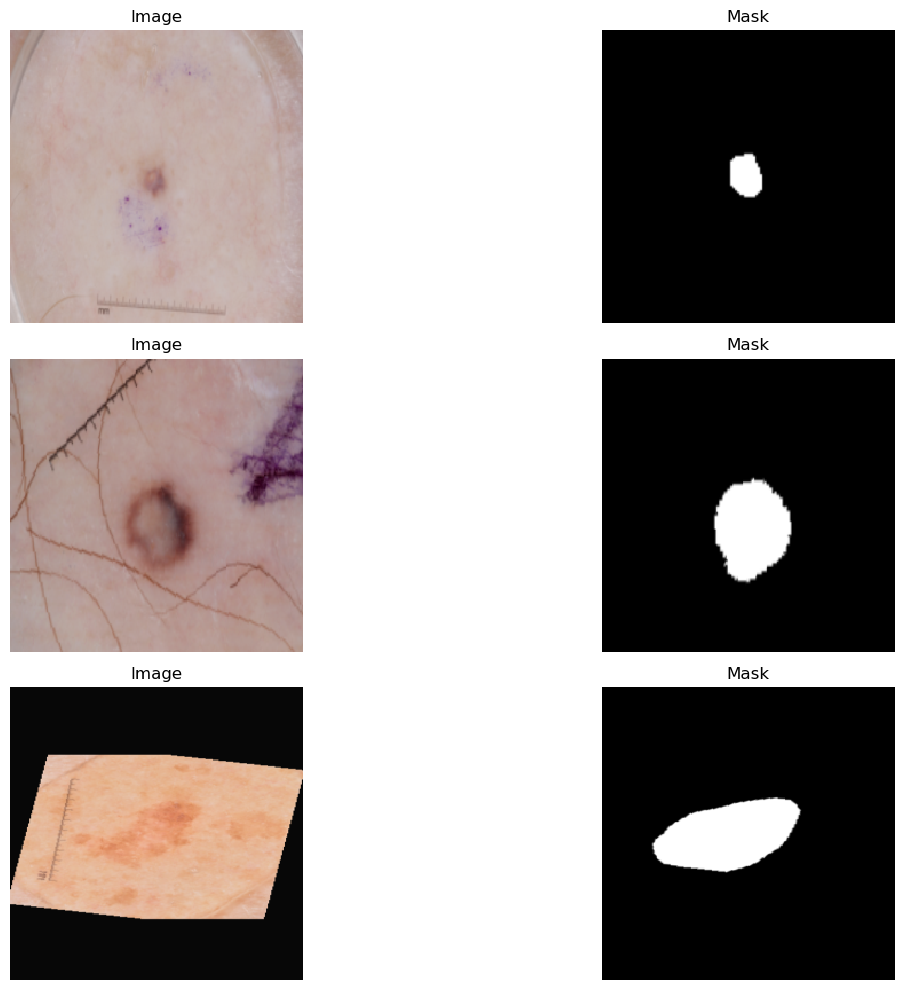

123
image count in valid path :100
123
image count in test path :1000
321


Res18Unetv1
The number of parameters: 67453953
2023-07-06 23:19:16.260580

best_model.pth
Image Size: 224 
Batch Size: 1
LR: 0.0001
Steps: 6200000



wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bduy2015 (baoduyy). Use `wandb login --relogin` to force relogin


Optimizer: AdamW
Loss: BCE Loss

====================================== Set up ===========================================
====================================== Trainning ===========================================
TRAIN [   1/6200000]  BCE Loss: 0.5634 LR: 5.000e-06 
TRAIN [ 100/6200000]  BCE Loss: 0.9936 LR: 5.627e-06 
TRAIN [ 200/6200000]  BCE Loss: 0.6443 LR: 6.260e-06 
TRAIN [ 300/6200000]  BCE Loss: 0.7530 LR: 6.894e-06 
TRAIN [ 400/6200000]  BCE Loss: 0.3280 LR: 7.527e-06 
TRAIN [ 500/6200000]  BCE Loss: 0.3551 LR: 8.160e-06 
TRAIN [ 600/6200000]  BCE Loss: 0.3218 LR: 8.794e-06 
TRAIN [ 700/6200000]  BCE Loss: 0.8570 LR: 9.427e-06 
TRAIN [ 800/6200000]  BCE Loss: 0.4001 LR: 1.006e-05 
TRAIN [ 900/6200000]  BCE Loss: 0.5601 LR: 1.069e-05 
TRAIN [1000/6200000]  BCE Loss: 0.8114 LR: 1.133e-05 
TRAIN [1100/6200000]  BCE Loss: 0.3732 LR: 1.196e-05 
TRAIN [1200/6200000]  BCE Loss: 0.1907 LR: 1.259e-05 
TRAIN [1300/6200000]  BCE Loss: 0.1922 LR: 1.323e-05 
TRAIN [1400/6200000]  BCE Lo

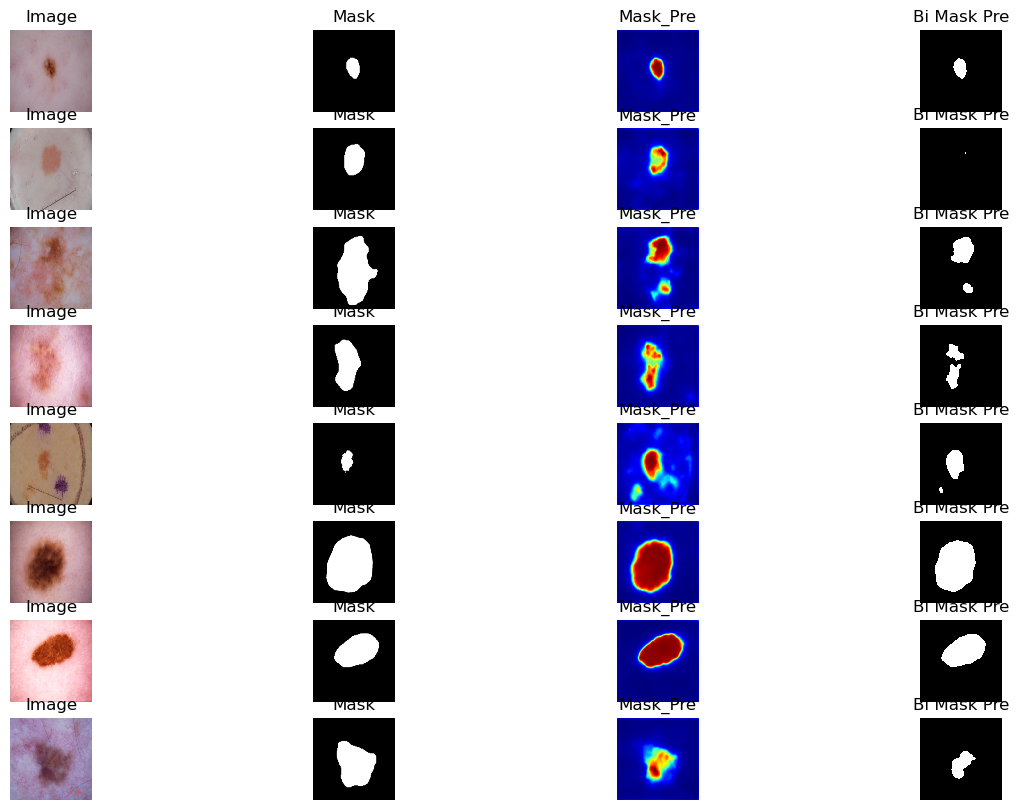

[Validation] Acc: 0.8668, SE: 0.7329, SP: 0.9458, PC: 0.8453, F1: 0.7288, JS: 0.6348, DC: 0.7288, unet_score: 1.3636
SAVE_MODEL
TRAIN [2600/6200000]  BCE Loss: 0.3965 LR: 2.146e-05 
TRAIN [2700/6200000]  BCE Loss: 0.3282 LR: 2.209e-05 
TRAIN [2800/6200000]  BCE Loss: 0.2665 LR: 2.273e-05 
TRAIN [2900/6200000]  BCE Loss: 0.1400 LR: 2.336e-05 
TRAIN [3000/6200000]  BCE Loss: 0.0813 LR: 2.399e-05 
TRAIN [3100/6200000]  BCE Loss: 0.1122 LR: 2.463e-05 
TRAIN [3200/6200000]  BCE Loss: 0.1012 LR: 2.526e-05 
TRAIN [3300/6200000]  BCE Loss: 0.5272 LR: 2.589e-05 
TRAIN [3400/6200000]  BCE Loss: 0.0637 LR: 2.653e-05 
TRAIN [3500/6200000]  BCE Loss: 0.2453 LR: 2.716e-05 
TRAIN [3600/6200000]  BCE Loss: 1.6503 LR: 2.779e-05 
TRAIN [3700/6200000]  BCE Loss: 0.5174 LR: 2.843e-05 
TRAIN [3800/6200000]  BCE Loss: 0.3268 LR: 2.906e-05 
TRAIN [3900/6200000]  BCE Loss: 0.3686 LR: 2.969e-05 
TRAIN [4000/6200000]  BCE Loss: 0.1460 LR: 3.033e-05 
TRAIN [4100/6200000]  BCE Loss: 0.0775 LR: 3.096e-05 
TRAIN [4

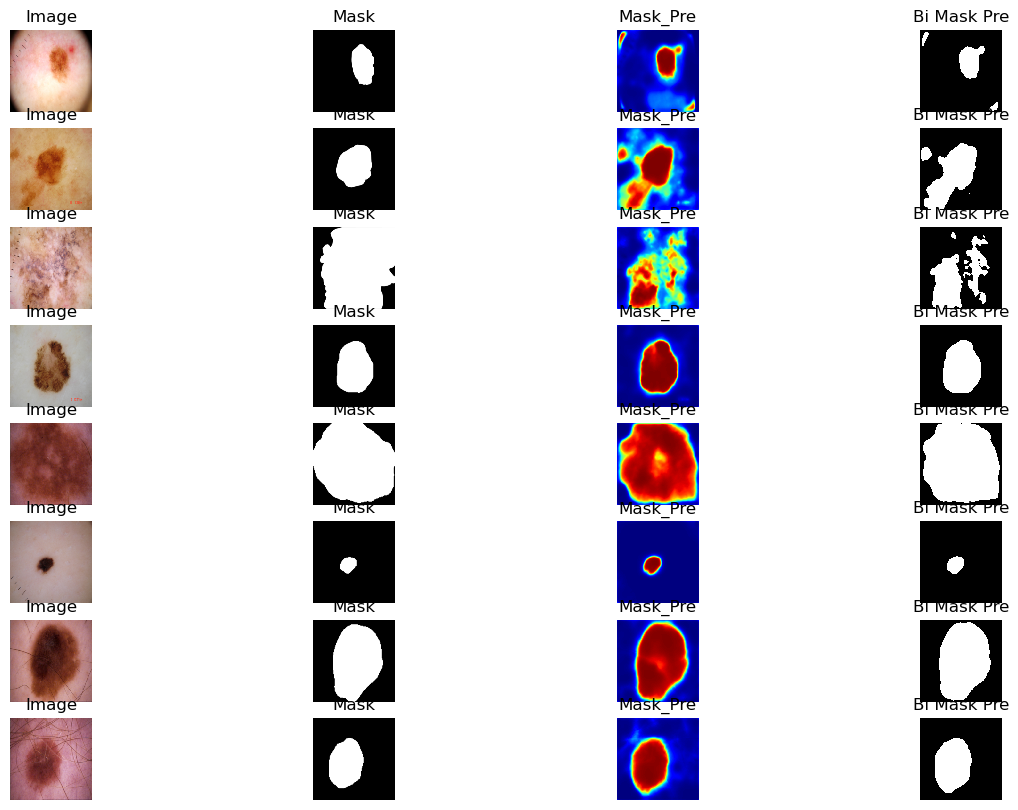

[Validation] Acc: 0.8996, SE: 0.8723, SP: 0.9248, PC: 0.8251, F1: 0.8157, JS: 0.7194, DC: 0.8157, unet_score: 1.5351
SAVE_MODEL
TRAIN [5200/6200000]  BCE Loss: 0.0712 LR: 3.793e-05 
TRAIN [5300/6200000]  BCE Loss: 0.1443 LR: 3.856e-05 
TRAIN [5400/6200000]  BCE Loss: 0.1253 LR: 3.919e-05 
TRAIN [5500/6200000]  BCE Loss: 0.0892 LR: 3.983e-05 
TRAIN [5600/6200000]  BCE Loss: 0.0517 LR: 4.046e-05 
TRAIN [5700/6200000]  BCE Loss: 0.0149 LR: 4.109e-05 
TRAIN [5800/6200000]  BCE Loss: 0.2533 LR: 4.173e-05 
TRAIN [5900/6200000]  BCE Loss: 0.0748 LR: 4.236e-05 
TRAIN [6000/6200000]  BCE Loss: 0.1093 LR: 4.299e-05 
TRAIN [6100/6200000]  BCE Loss: 0.0349 LR: 4.363e-05 
TRAIN [6200/6200000]  BCE Loss: 0.1452 LR: 4.426e-05 
TRAIN [6300/6200000]  BCE Loss: 0.1478 LR: 4.489e-05 
TRAIN [6400/6200000]  BCE Loss: 0.1738 LR: 4.553e-05 
TRAIN [6500/6200000]  BCE Loss: 0.0889 LR: 4.616e-05 
TRAIN [6600/6200000]  BCE Loss: 0.3173 LR: 4.679e-05 
TRAIN [6700/6200000]  BCE Loss: 0.2375 LR: 4.743e-05 
TRAIN [6

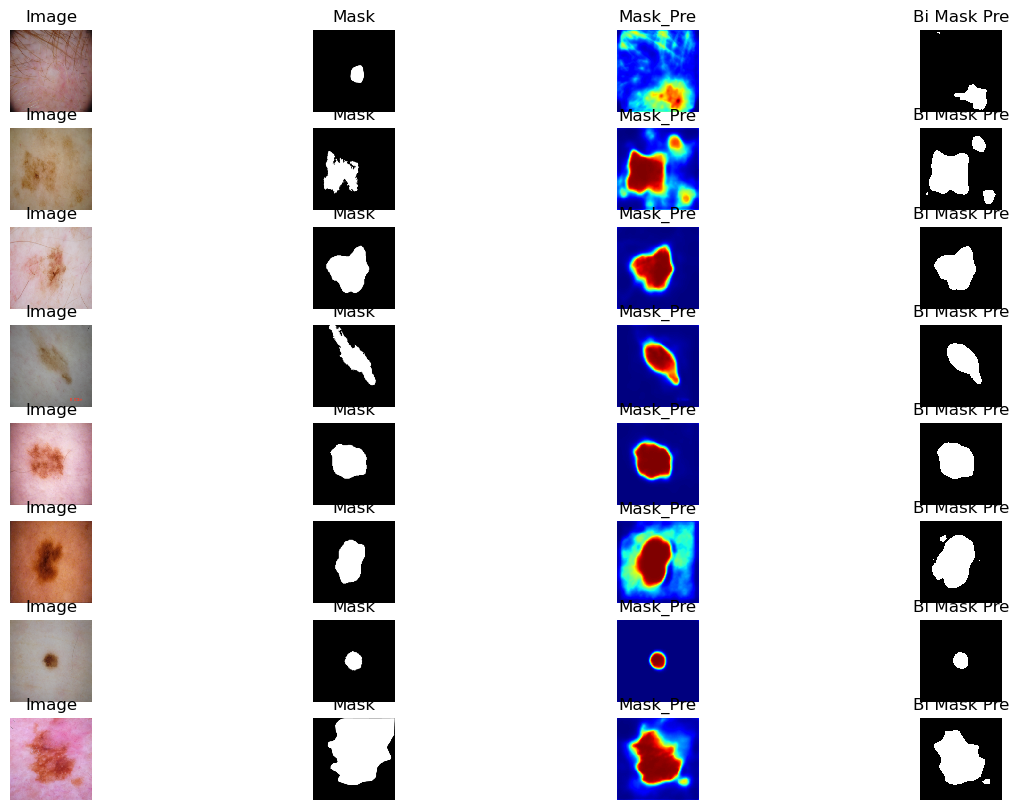

[Validation] Acc: 0.9110, SE: 0.9045, SP: 0.9174, PC: 0.8084, F1: 0.8286, JS: 0.7356, DC: 0.8286, unet_score: 1.5642
SAVE_MODEL
TRAIN [7800/6200000]  BCE Loss: 0.0386 LR: 5.439e-05 
TRAIN [7900/6200000]  BCE Loss: 0.3624 LR: 5.503e-05 
TRAIN [8000/6200000]  BCE Loss: 0.6168 LR: 5.566e-05 
TRAIN [8100/6200000]  BCE Loss: 0.1459 LR: 5.629e-05 
TRAIN [8200/6200000]  BCE Loss: 0.2035 LR: 5.693e-05 
TRAIN [8300/6200000]  BCE Loss: 0.4323 LR: 5.756e-05 
TRAIN [8400/6200000]  BCE Loss: 0.0467 LR: 5.819e-05 
TRAIN [8500/6200000]  BCE Loss: 0.0717 LR: 5.883e-05 
TRAIN [8600/6200000]  BCE Loss: 0.0200 LR: 5.946e-05 
TRAIN [8700/6200000]  BCE Loss: 0.0119 LR: 6.009e-05 
TRAIN [8800/6200000]  BCE Loss: 0.0550 LR: 6.073e-05 
TRAIN [8900/6200000]  BCE Loss: 0.0264 LR: 6.136e-05 
TRAIN [9000/6200000]  BCE Loss: 5.3896 LR: 6.199e-05 
TRAIN [9100/6200000]  BCE Loss: 0.1194 LR: 6.263e-05 
TRAIN [9300/6200000]  BCE Loss: 0.4174 LR: 6.389e-05 
TRAIN [9400/6200000]  BCE Loss: 0.0115 LR: 6.453e-05 
TRAIN [9

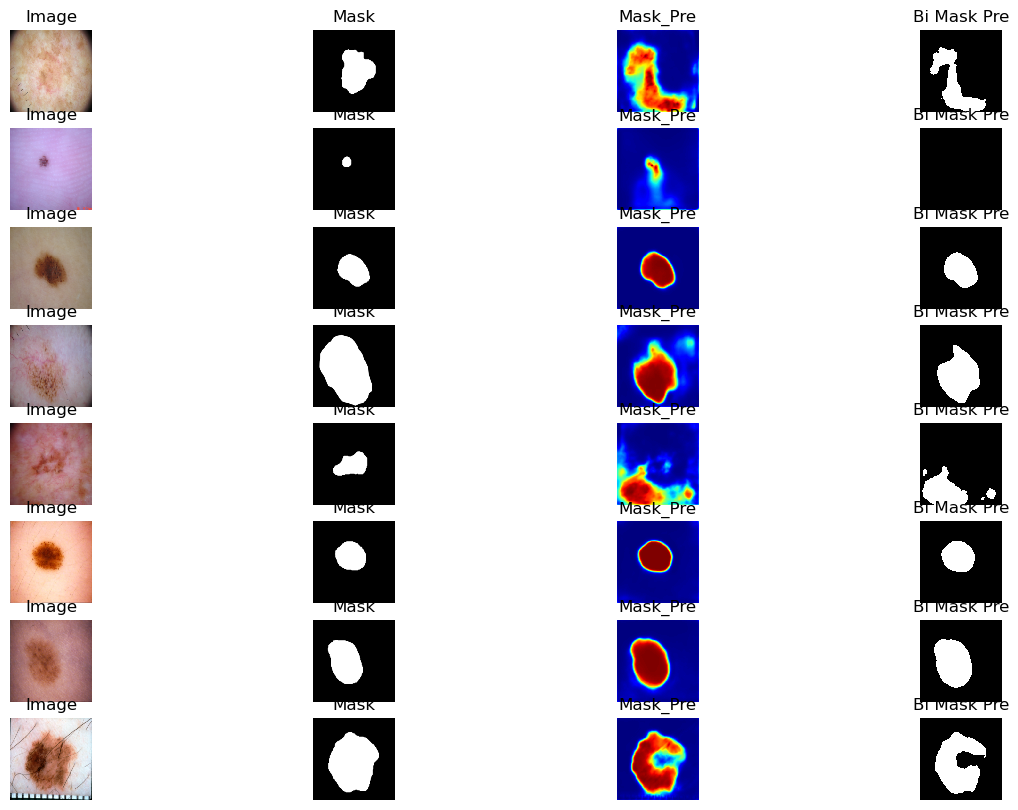

[Validation] Acc: 0.8879, SE: 0.8373, SP: 0.9288, PC: 0.8043, F1: 0.7907, JS: 0.6928, DC: 0.7907, unet_score: 1.4835
TRAIN [10400/6200000]  BCE Loss: 0.2332 LR: 7.086e-05 
TRAIN [10500/6200000]  BCE Loss: 0.1602 LR: 7.149e-05 
TRAIN [10600/6200000]  BCE Loss: 0.1777 LR: 7.213e-05 
TRAIN [10700/6200000]  BCE Loss: 0.2242 LR: 7.276e-05 
TRAIN [10800/6200000]  BCE Loss: 0.0313 LR: 7.339e-05 
TRAIN [10900/6200000]  BCE Loss: 0.0732 LR: 7.403e-05 
TRAIN [11000/6200000]  BCE Loss: 0.6661 LR: 7.466e-05 
TRAIN [11100/6200000]  BCE Loss: 0.1109 LR: 7.529e-05 
TRAIN [11200/6200000]  BCE Loss: 0.0541 LR: 7.593e-05 
TRAIN [11300/6200000]  BCE Loss: 0.0990 LR: 7.656e-05 
TRAIN [11400/6200000]  BCE Loss: 0.1312 LR: 7.719e-05 
TRAIN [11500/6200000]  BCE Loss: 0.0159 LR: 7.783e-05 
TRAIN [11600/6200000]  BCE Loss: 0.1291 LR: 7.846e-05 
TRAIN [11700/6200000]  BCE Loss: 0.0603 LR: 7.909e-05 
TRAIN [11800/6200000]  BCE Loss: 0.1290 LR: 7.973e-05 
TRAIN [11900/6200000]  BCE Loss: 0.0587 LR: 8.036e-05 
TRA

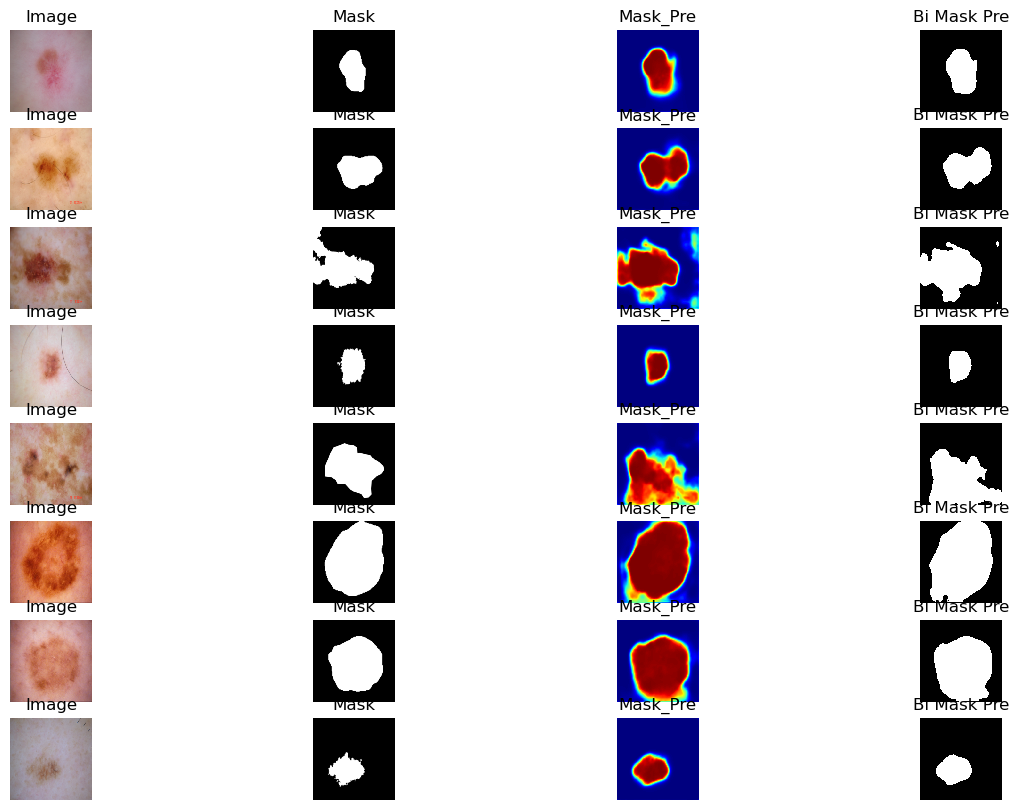

[Validation] Acc: 0.9054, SE: 0.8861, SP: 0.9156, PC: 0.7908, F1: 0.8145, JS: 0.7210, DC: 0.8145, unet_score: 1.5356
TRAIN [13000/6200000]  BCE Loss: 0.2044 LR: 8.733e-05 
TRAIN [13100/6200000]  BCE Loss: 0.0331 LR: 8.796e-05 
TRAIN [13200/6200000]  BCE Loss: 0.0649 LR: 8.859e-05 
TRAIN [13300/6200000]  BCE Loss: 0.0233 LR: 8.923e-05 
TRAIN [13400/6200000]  BCE Loss: 0.1490 LR: 8.986e-05 
TRAIN [13500/6200000]  BCE Loss: 0.0181 LR: 9.049e-05 
TRAIN [13600/6200000]  BCE Loss: 0.1768 LR: 9.113e-05 
TRAIN [13700/6200000]  BCE Loss: 0.0816 LR: 9.176e-05 
TRAIN [13800/6200000]  BCE Loss: 0.0694 LR: 9.239e-05 
TRAIN [13900/6200000]  BCE Loss: 0.2246 LR: 9.303e-05 
TRAIN [14000/6200000]  BCE Loss: 0.2735 LR: 9.366e-05 
TRAIN [14100/6200000]  BCE Loss: 0.0186 LR: 9.429e-05 
TRAIN [14200/6200000]  BCE Loss: 0.2099 LR: 9.493e-05 
TRAIN [14300/6200000]  BCE Loss: 0.4336 LR: 9.556e-05 
TRAIN [14400/6200000]  BCE Loss: 0.0824 LR: 9.619e-05 
TRAIN [14500/6200000]  BCE Loss: 0.0256 LR: 9.683e-05 
TRA

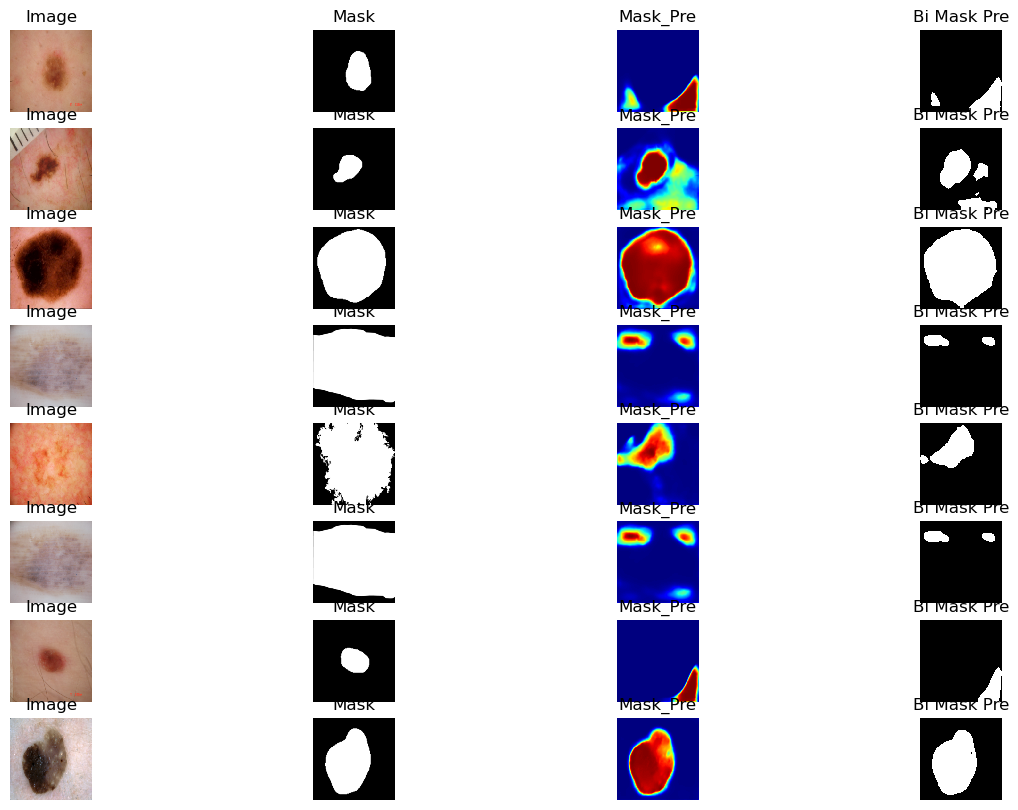

[Validation] Acc: 0.8247, SE: 0.6681, SP: 0.8894, PC: 0.6424, F1: 0.6013, JS: 0.4961, DC: 0.6013, unet_score: 1.0975
TRAIN [15600/6200000]  BCE Loss: 0.0098 LR: 9.979e-05 
TRAIN [15700/6200000]  BCE Loss: 0.1891 LR: 9.971e-05 
TRAIN [15800/6200000]  BCE Loss: 0.0205 LR: 9.963e-05 
TRAIN [15900/6200000]  BCE Loss: 0.1188 LR: 9.953e-05 
TRAIN [16000/6200000]  BCE Loss: 0.0298 LR: 9.942e-05 
TRAIN [16100/6200000]  BCE Loss: 0.0297 LR: 9.929e-05 
TRAIN [16200/6200000]  BCE Loss: 0.0555 LR: 9.916e-05 
TRAIN [16300/6200000]  BCE Loss: 0.0831 LR: 9.901e-05 
TRAIN [16400/6200000]  BCE Loss: 0.0971 LR: 9.886e-05 
TRAIN [16500/6200000]  BCE Loss: 0.1627 LR: 9.869e-05 
TRAIN [16600/6200000]  BCE Loss: 0.1255 LR: 9.851e-05 
TRAIN [16700/6200000]  BCE Loss: 0.0114 LR: 9.832e-05 
TRAIN [16800/6200000]  BCE Loss: 0.0219 LR: 9.812e-05 
TRAIN [16900/6200000]  BCE Loss: 0.0792 LR: 9.790e-05 
TRAIN [17000/6200000]  BCE Loss: 0.0086 LR: 9.768e-05 
TRAIN [17100/6200000]  BCE Loss: 0.0773 LR: 9.744e-05 
TRA

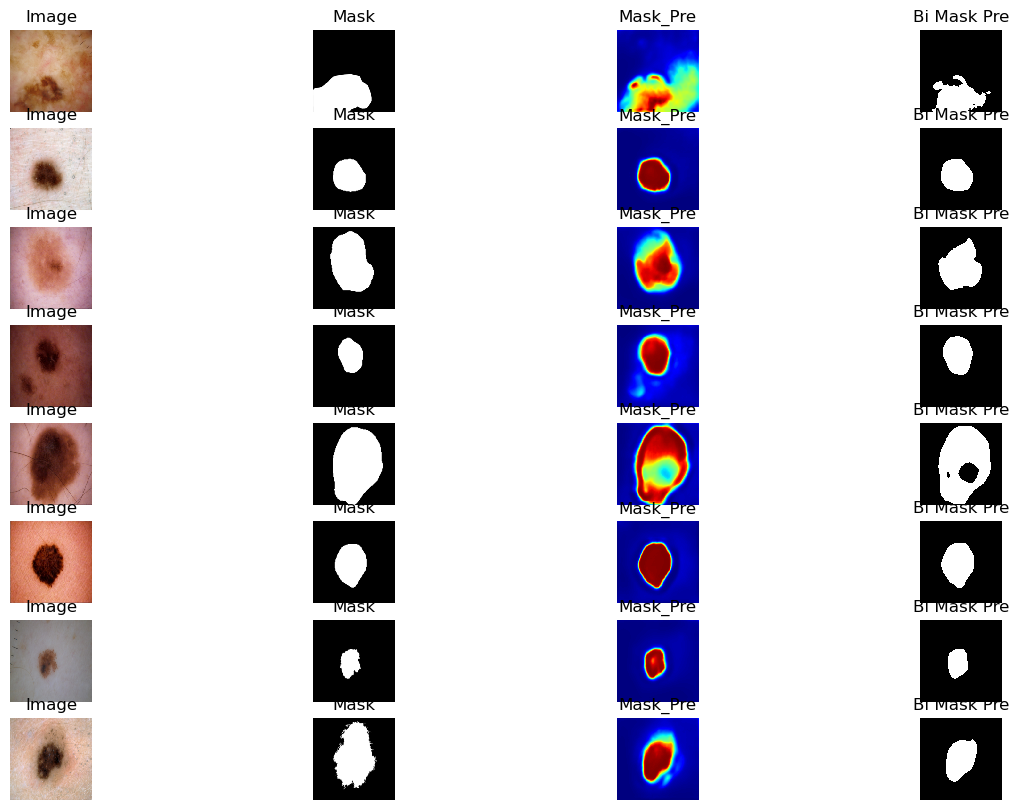

[Validation] Acc: 0.8344, SE: 0.5735, SP: 0.9756, PC: 0.7507, F1: 0.5863, JS: 0.5044, DC: 0.5863, unet_score: 1.0907
TRAIN [18200/6200000]  BCE Loss: 0.1797 LR: 9.413e-05 
TRAIN [18300/6200000]  BCE Loss: 0.1301 LR: 9.376e-05 
TRAIN [18400/6200000]  BCE Loss: 0.0550 LR: 9.339e-05 
TRAIN [18500/6200000]  BCE Loss: 0.0290 LR: 9.300e-05 
TRAIN [18600/6200000]  BCE Loss: 0.2210 LR: 9.261e-05 
TRAIN [18700/6200000]  BCE Loss: 0.0282 LR: 9.220e-05 
TRAIN [18800/6200000]  BCE Loss: 0.0653 LR: 9.179e-05 
TRAIN [18900/6200000]  BCE Loss: 0.0052 LR: 9.137e-05 
TRAIN [19000/6200000]  BCE Loss: 0.0077 LR: 9.093e-05 
TRAIN [19100/6200000]  BCE Loss: 0.0989 LR: 9.049e-05 
TRAIN [19200/6200000]  BCE Loss: 0.1830 LR: 9.004e-05 
TRAIN [19300/6200000]  BCE Loss: 0.0235 LR: 8.958e-05 
TRAIN [19400/6200000]  BCE Loss: 0.0371 LR: 8.910e-05 
TRAIN [19500/6200000]  BCE Loss: 0.1460 LR: 8.862e-05 
TRAIN [19600/6200000]  BCE Loss: 0.0152 LR: 8.814e-05 
TRAIN [19700/6200000]  BCE Loss: 0.3775 LR: 8.764e-05 
TRA

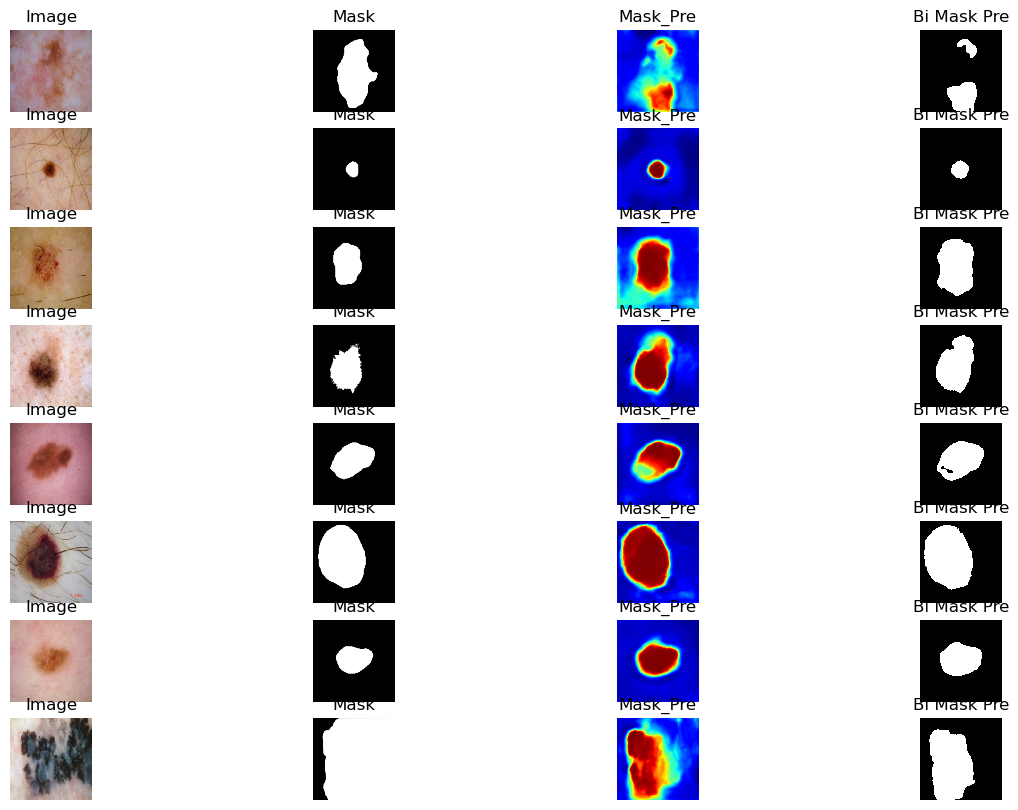

[Validation] Acc: 0.8823, SE: 0.8396, SP: 0.9097, PC: 0.7359, F1: 0.7437, JS: 0.6303, DC: 0.7437, unet_score: 1.3740
TRAIN [20800/6200000]  BCE Loss: 0.6741 LR: 8.162e-05 
TRAIN [20900/6200000]  BCE Loss: 0.0342 LR: 8.103e-05 
TRAIN [21000/6200000]  BCE Loss: 0.0904 LR: 8.043e-05 
TRAIN [21100/6200000]  BCE Loss: 0.0699 LR: 7.982e-05 
TRAIN [21200/6200000]  BCE Loss: 0.0755 LR: 7.921e-05 
TRAIN [21300/6200000]  BCE Loss: 0.1410 LR: 7.858e-05 
TRAIN [21400/6200000]  BCE Loss: 0.2907 LR: 7.796e-05 
TRAIN [21500/6200000]  BCE Loss: 0.0206 LR: 7.733e-05 
TRAIN [21600/6200000]  BCE Loss: 0.0165 LR: 7.669e-05 
TRAIN [21700/6200000]  BCE Loss: 0.0204 LR: 7.604e-05 
TRAIN [21800/6200000]  BCE Loss: 0.0592 LR: 7.539e-05 
TRAIN [21900/6200000]  BCE Loss: 0.0452 LR: 7.473e-05 
TRAIN [22000/6200000]  BCE Loss: 0.0235 LR: 7.407e-05 
TRAIN [22100/6200000]  BCE Loss: 0.0429 LR: 7.340e-05 
TRAIN [22200/6200000]  BCE Loss: 0.1782 LR: 7.273e-05 
TRAIN [22300/6200000]  BCE Loss: 0.0567 LR: 7.205e-05 
TRA

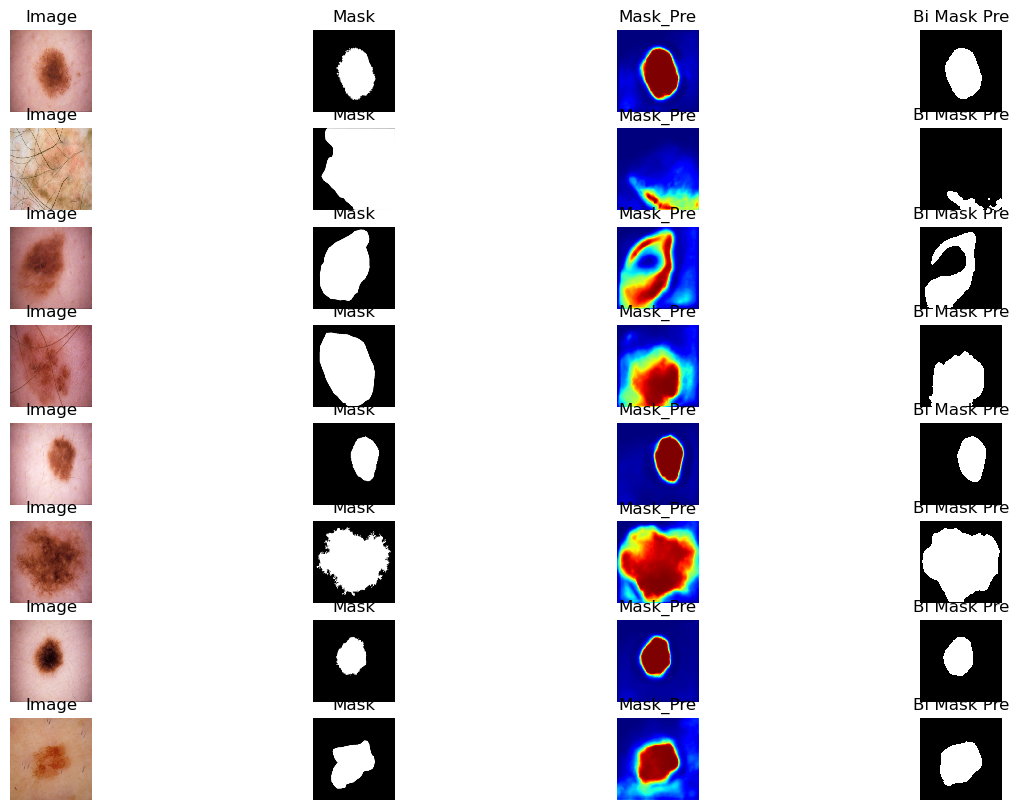

[Validation] Acc: 0.8813, SE: 0.8086, SP: 0.9387, PC: 0.7941, F1: 0.7663, JS: 0.6666, DC: 0.7663, unet_score: 1.4329
TRAIN [23400/6200000]  BCE Loss: 0.0125 LR: 6.432e-05 
TRAIN [23500/6200000]  BCE Loss: 0.2532 LR: 6.360e-05 
TRAIN [23600/6200000]  BCE Loss: 0.0738 LR: 6.287e-05 
TRAIN [23700/6200000]  BCE Loss: 0.0310 LR: 6.214e-05 
TRAIN [23800/6200000]  BCE Loss: 0.0329 LR: 6.141e-05 
TRAIN [23900/6200000]  BCE Loss: 0.1079 LR: 6.067e-05 
TRAIN [24000/6200000]  BCE Loss: 0.0921 LR: 5.994e-05 
TRAIN [24100/6200000]  BCE Loss: 0.5328 LR: 5.920e-05 
TRAIN [24200/6200000]  BCE Loss: 0.0264 LR: 5.846e-05 
TRAIN [24300/6200000]  BCE Loss: 0.1796 LR: 5.772e-05 
TRAIN [24400/6200000]  BCE Loss: 0.0093 LR: 5.698e-05 
TRAIN [24500/6200000]  BCE Loss: 0.0413 LR: 5.623e-05 
TRAIN [24600/6200000]  BCE Loss: 0.0692 LR: 5.549e-05 
TRAIN [24700/6200000]  BCE Loss: 0.1320 LR: 5.475e-05 
TRAIN [24800/6200000]  BCE Loss: 0.0073 LR: 5.400e-05 
TRAIN [24900/6200000]  BCE Loss: 0.0059 LR: 5.325e-05 
TRA

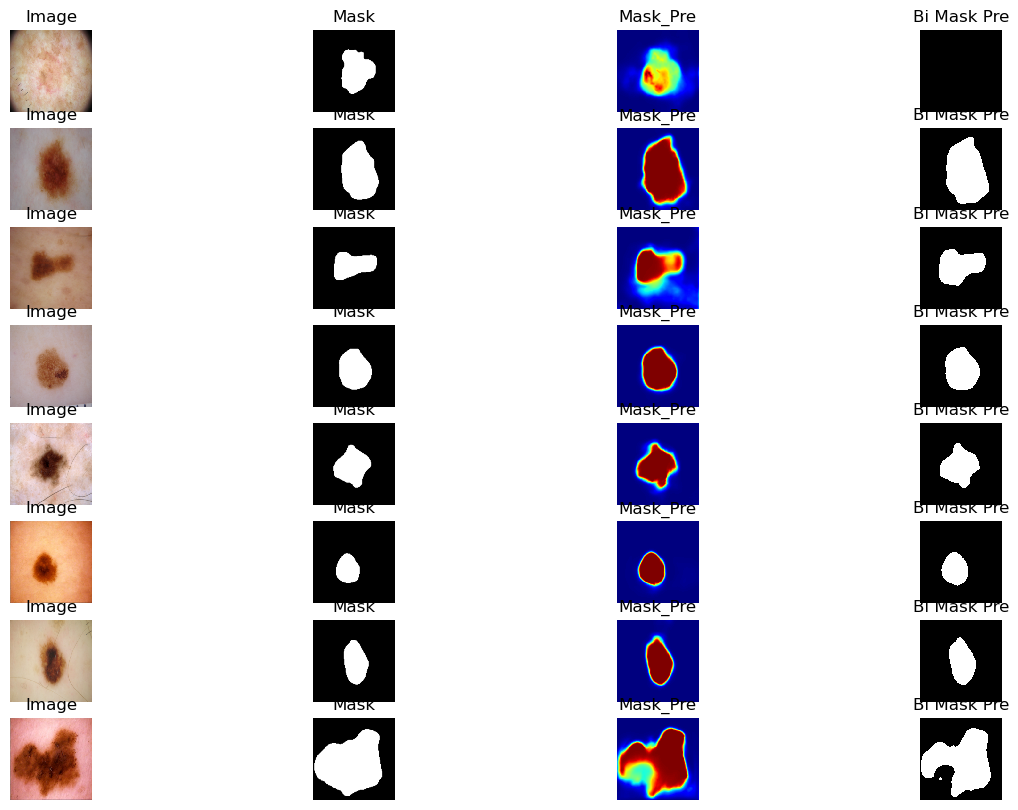

[Validation] Acc: 0.8846, SE: 0.7827, SP: 0.9578, PC: 0.8140, F1: 0.7567, JS: 0.6609, DC: 0.7567, unet_score: 1.4175
TRAIN [26000/6200000]  BCE Loss: 0.0069 LR: 4.508e-05 
TRAIN [26100/6200000]  BCE Loss: 0.2447 LR: 4.434e-05 
TRAIN [26200/6200000]  BCE Loss: 0.0539 LR: 4.361e-05 
TRAIN [26300/6200000]  BCE Loss: 0.0712 LR: 4.287e-05 
TRAIN [26400/6200000]  BCE Loss: 0.0138 LR: 4.215e-05 
TRAIN [26500/6200000]  BCE Loss: 0.0570 LR: 4.142e-05 
TRAIN [26600/6200000]  BCE Loss: 0.1374 LR: 4.069e-05 
TRAIN [26700/6200000]  BCE Loss: 0.0098 LR: 3.997e-05 
TRAIN [26800/6200000]  BCE Loss: 0.9435 LR: 3.926e-05 
TRAIN [26900/6200000]  BCE Loss: 0.0599 LR: 3.854e-05 
TRAIN [27000/6200000]  BCE Loss: 0.0899 LR: 3.783e-05 
TRAIN [27100/6200000]  BCE Loss: 0.0176 LR: 3.712e-05 
TRAIN [27200/6200000]  BCE Loss: 0.0428 LR: 3.642e-05 
TRAIN [27300/6200000]  BCE Loss: 0.0753 LR: 3.572e-05 
TRAIN [27400/6200000]  BCE Loss: 0.0279 LR: 3.502e-05 
TRAIN [27500/6200000]  BCE Loss: 0.0221 LR: 3.433e-05 
TRA

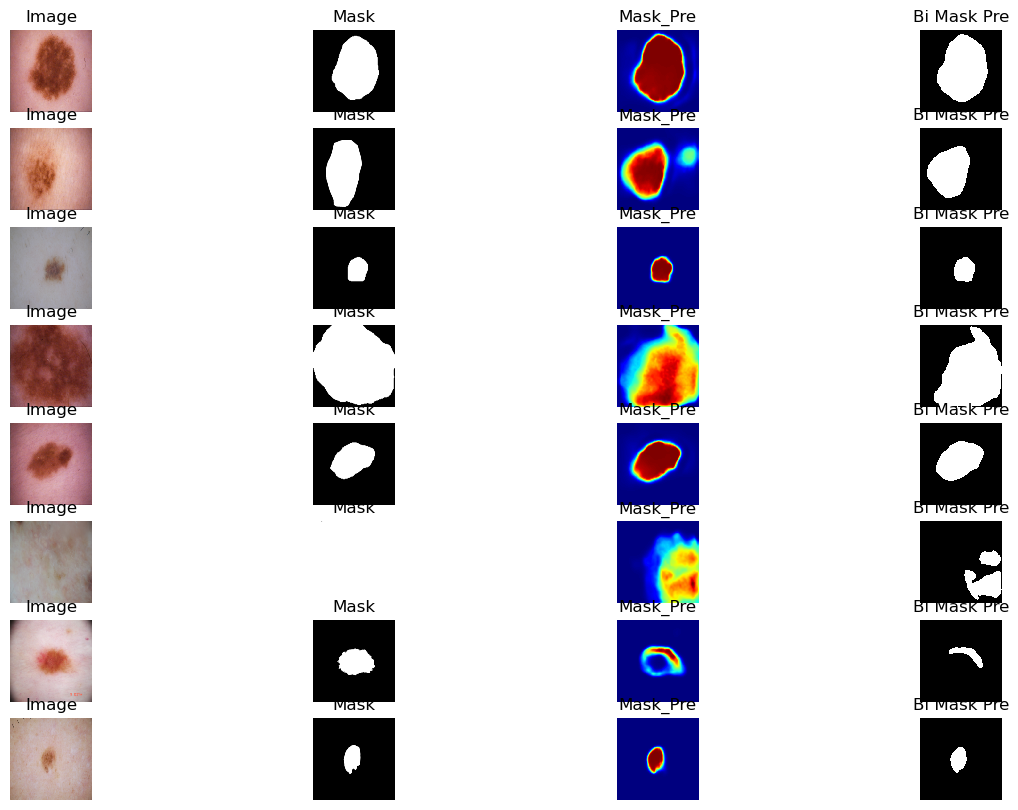

[Validation] Acc: 0.8751, SE: 0.8052, SP: 0.9266, PC: 0.7763, F1: 0.7480, JS: 0.6460, DC: 0.7480, unet_score: 1.3940
TRAIN [28600/6200000]  BCE Loss: 0.0881 LR: 2.705e-05 
TRAIN [28700/6200000]  BCE Loss: 0.0890 LR: 2.643e-05 
TRAIN [28800/6200000]  BCE Loss: 0.1499 LR: 2.581e-05 
TRAIN [28900/6200000]  BCE Loss: 0.2020 LR: 2.519e-05 
TRAIN [29000/6200000]  BCE Loss: 0.0316 LR: 2.459e-05 
TRAIN [29100/6200000]  BCE Loss: 0.2070 LR: 2.399e-05 
TRAIN [29200/6200000]  BCE Loss: 0.0229 LR: 2.339e-05 
TRAIN [29300/6200000]  BCE Loss: 0.0641 LR: 2.281e-05 
TRAIN [29400/6200000]  BCE Loss: 0.0491 LR: 2.223e-05 
TRAIN [29500/6200000]  BCE Loss: 0.0748 LR: 2.166e-05 
TRAIN [29600/6200000]  BCE Loss: 0.0689 LR: 2.109e-05 
TRAIN [29700/6200000]  BCE Loss: 0.1106 LR: 2.054e-05 
TRAIN [29800/6200000]  BCE Loss: 0.0071 LR: 1.999e-05 
TRAIN [29900/6200000]  BCE Loss: 0.0641 LR: 1.945e-05 
TRAIN [30000/6200000]  BCE Loss: 0.0229 LR: 1.892e-05 
TRAIN [30100/6200000]  BCE Loss: 0.9152 LR: 1.839e-05 
TRA

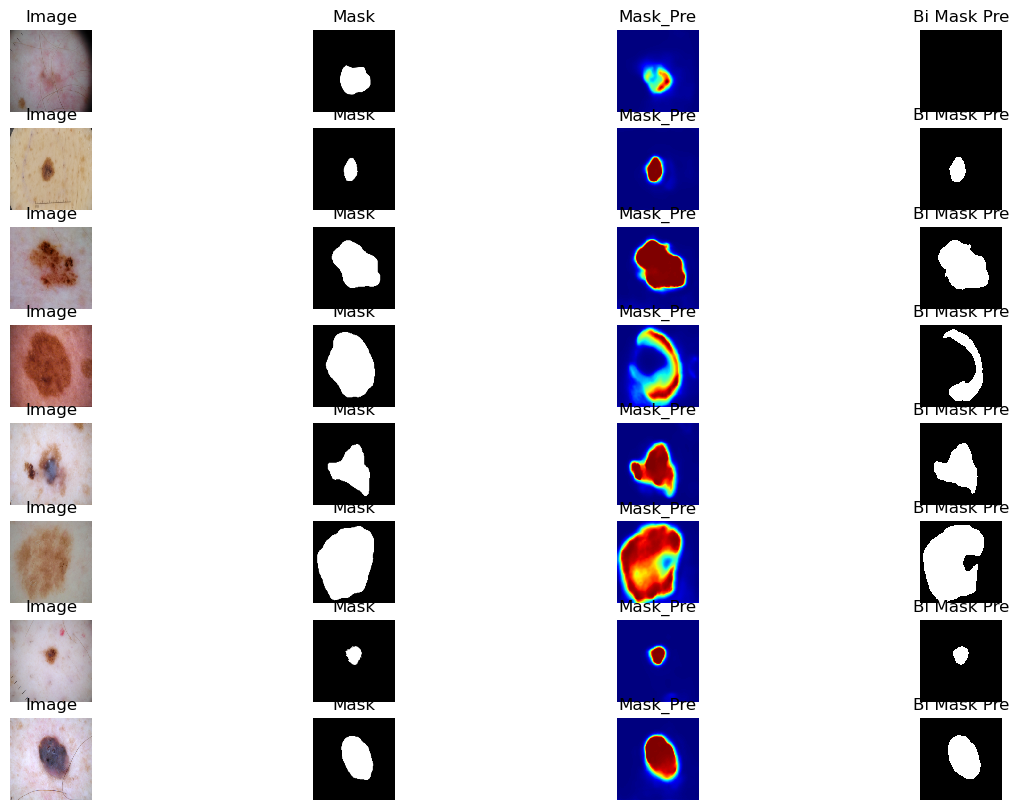

[Validation] Acc: 0.8623, SE: 0.7299, SP: 0.9470, PC: 0.7724, F1: 0.6966, JS: 0.5939, DC: 0.6966, unet_score: 1.2905
TRAIN [31200/6200000]  BCE Loss: 0.0117 LR: 1.322e-05 
TRAIN [31300/6200000]  BCE Loss: 0.0456 LR: 1.280e-05 
TRAIN [31400/6200000]  BCE Loss: 0.0588 LR: 1.240e-05 
TRAIN [31500/6200000]  BCE Loss: 0.0365 LR: 1.200e-05 
TRAIN [31600/6200000]  BCE Loss: 0.2003 LR: 1.162e-05 
TRAIN [31700/6200000]  BCE Loss: 0.1201 LR: 1.124e-05 
TRAIN [31800/6200000]  BCE Loss: 0.1876 LR: 1.088e-05 
TRAIN [31900/6200000]  BCE Loss: 0.0267 LR: 1.052e-05 
TRAIN [32000/6200000]  BCE Loss: 0.0392 LR: 1.018e-05 
TRAIN [32100/6200000]  BCE Loss: 0.0066 LR: 9.847e-06 
TRAIN [32200/6200000]  BCE Loss: 0.0108 LR: 9.524e-06 
TRAIN [32300/6200000]  BCE Loss: 0.0348 LR: 9.211e-06 
TRAIN [32400/6200000]  BCE Loss: 0.0359 LR: 8.910e-06 
TRAIN [32500/6200000]  BCE Loss: 0.1569 LR: 8.619e-06 
TRAIN [32600/6200000]  BCE Loss: 0.2745 LR: 8.338e-06 
TRAIN [32700/6200000]  BCE Loss: 0.1179 LR: 8.069e-06 
TRA

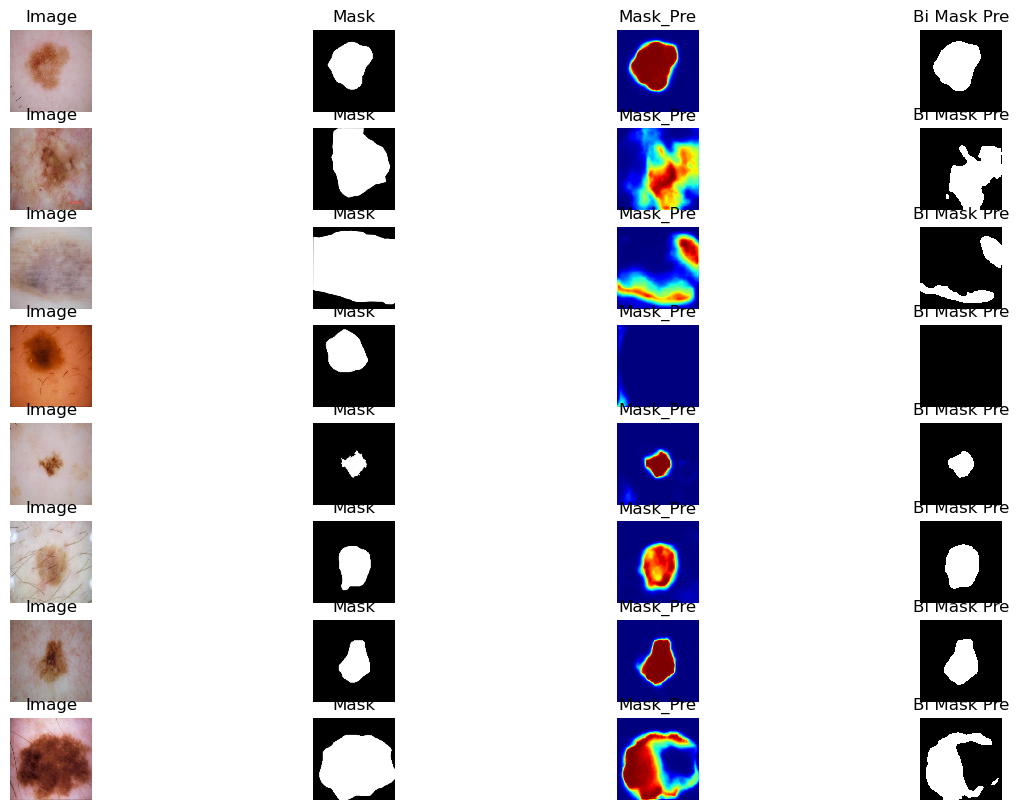

[Validation] Acc: 0.8446, SE: 0.7157, SP: 0.9214, PC: 0.7241, F1: 0.6605, JS: 0.5563, DC: 0.6605, unet_score: 1.2169
TRAIN [33800/6200000]  BCE Loss: 0.1634 LR: 5.843e-06 
TRAIN [33900/6200000]  BCE Loss: 0.0173 LR: 5.709e-06 
TRAIN [34000/6200000]  BCE Loss: 0.0106 LR: 5.586e-06 
TRAIN [34100/6200000]  BCE Loss: 0.0660 LR: 5.475e-06 
TRAIN [34200/6200000]  BCE Loss: 0.0231 LR: 5.375e-06 
TRAIN [34300/6200000]  BCE Loss: 0.0696 LR: 5.288e-06 
TRAIN [34400/6200000]  BCE Loss: 0.0813 LR: 5.212e-06 
TRAIN [34500/6200000]  BCE Loss: 0.0154 LR: 5.147e-06 
TRAIN [34600/6200000]  BCE Loss: 0.0519 LR: 5.094e-06 
TRAIN [34700/6200000]  BCE Loss: 0.0362 LR: 5.053e-06 
TRAIN [34800/6200000]  BCE Loss: 0.1085 LR: 5.024e-06 
TRAIN [34900/6200000]  BCE Loss: 0.1410 LR: 5.006e-06 
TRAIN [35000/6200000]  BCE Loss: 0.0679 LR: 5.000e-06 
TRAIN [35100/6200000]  BCE Loss: 0.0531 LR: 5.561e-06 
TRAIN [35200/6200000]  BCE Loss: 1.0248 LR: 6.128e-06 
TRAIN [35300/6200000]  BCE Loss: 0.1307 LR: 6.694e-06 
TRA

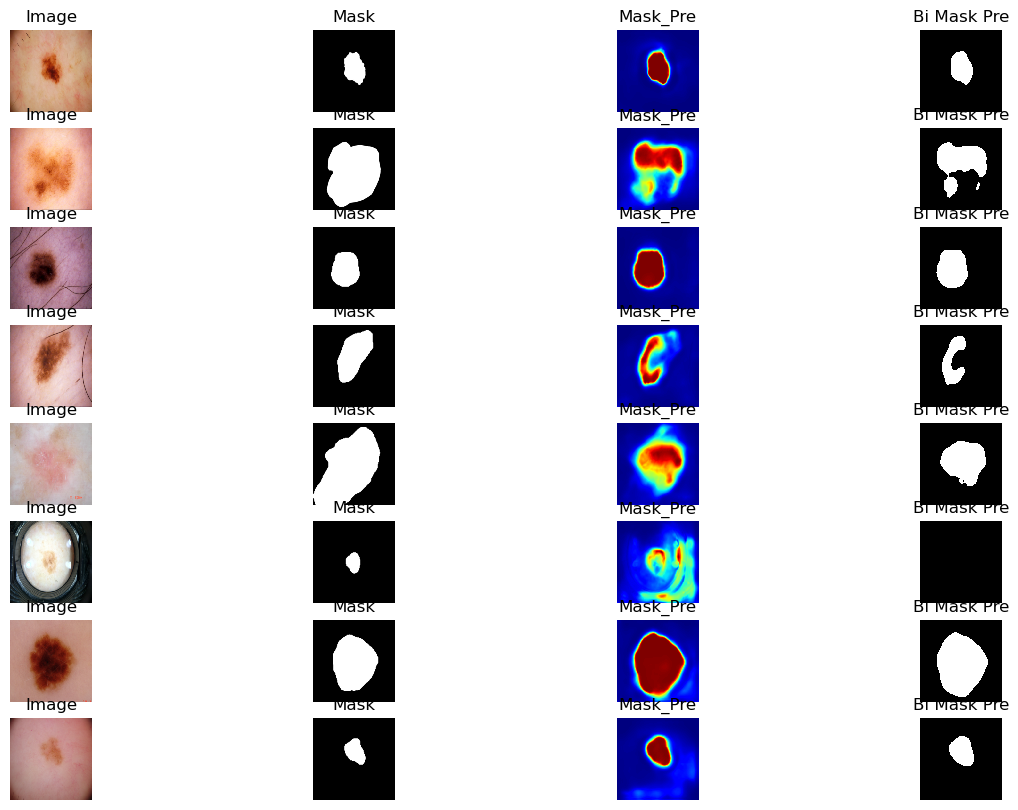

[Validation] Acc: 0.8664, SE: 0.7790, SP: 0.9234, PC: 0.7883, F1: 0.7245, JS: 0.6219, DC: 0.7245, unet_score: 1.3464
TRAIN [36400/6200000]  BCE Loss: 0.1539 LR: 1.293e-05 
TRAIN [36500/6200000]  BCE Loss: 0.0219 LR: 1.349e-05 
TRAIN [36600/6200000]  BCE Loss: 0.3343 LR: 1.406e-05 
TRAIN [36700/6200000]  BCE Loss: 0.1075 LR: 1.463e-05 
TRAIN [36800/6200000]  BCE Loss: 0.0432 LR: 1.519e-05 
TRAIN [36900/6200000]  BCE Loss: 0.0226 LR: 1.576e-05 
TRAIN [37000/6200000]  BCE Loss: 0.0294 LR: 1.633e-05 
TRAIN [37100/6200000]  BCE Loss: 0.1284 LR: 1.689e-05 
TRAIN [37200/6200000]  BCE Loss: 0.1310 LR: 1.746e-05 
TRAIN [37300/6200000]  BCE Loss: 0.4097 LR: 1.803e-05 
TRAIN [37400/6200000]  BCE Loss: 0.0298 LR: 1.859e-05 
TRAIN [37500/6200000]  BCE Loss: 0.1569 LR: 1.916e-05 
TRAIN [37600/6200000]  BCE Loss: 0.0215 LR: 1.973e-05 
TRAIN [37700/6200000]  BCE Loss: 0.1004 LR: 2.029e-05 
TRAIN [37800/6200000]  BCE Loss: 0.0486 LR: 2.086e-05 
TRAIN [37900/6200000]  BCE Loss: 0.0849 LR: 2.143e-05 
TRA

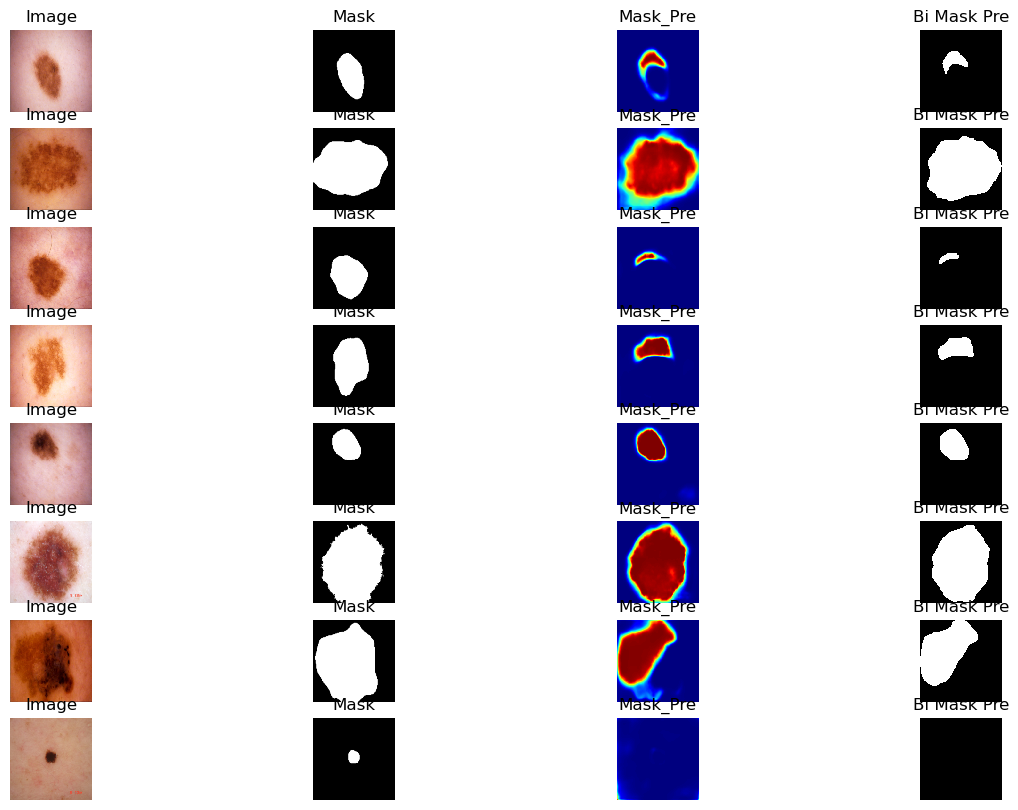

[Validation] Acc: 0.8424, SE: 0.5943, SP: 0.9702, PC: 0.7430, F1: 0.6055, JS: 0.5183, DC: 0.6055, unet_score: 1.1238
TRAIN [39000/6200000]  BCE Loss: 0.0431 LR: 2.766e-05 
TRAIN [39100/6200000]  BCE Loss: 0.0113 LR: 2.823e-05 
TRAIN [39200/6200000]  BCE Loss: 0.0197 LR: 2.879e-05 
TRAIN [39300/6200000]  BCE Loss: 0.0103 LR: 2.936e-05 
TRAIN [39400/6200000]  BCE Loss: 0.0098 LR: 2.993e-05 
TRAIN [39500/6200000]  BCE Loss: 0.0940 LR: 3.049e-05 
TRAIN [39600/6200000]  BCE Loss: 0.2032 LR: 3.106e-05 
TRAIN [39700/6200000]  BCE Loss: 0.1811 LR: 3.163e-05 
TRAIN [39800/6200000]  BCE Loss: 0.0155 LR: 3.219e-05 
TRAIN [39900/6200000]  BCE Loss: 0.0721 LR: 3.276e-05 
TRAIN [40000/6200000]  BCE Loss: 0.0545 LR: 3.333e-05 
TRAIN [40100/6200000]  BCE Loss: 0.0756 LR: 3.389e-05 
TRAIN [40200/6200000]  BCE Loss: 0.0742 LR: 3.446e-05 
TRAIN [40300/6200000]  BCE Loss: 0.1100 LR: 3.503e-05 
TRAIN [40400/6200000]  BCE Loss: 0.0093 LR: 3.559e-05 
TRAIN [40500/6200000]  BCE Loss: 0.0317 LR: 3.616e-05 
TRA

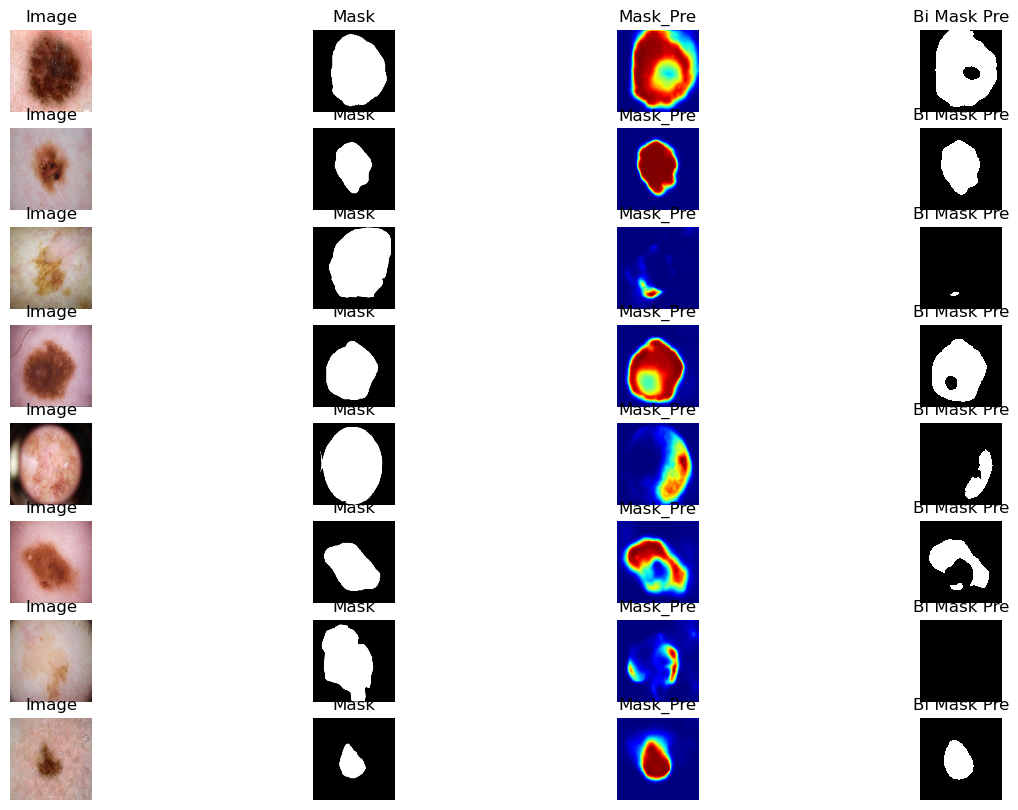

[Validation] Acc: 0.8372, SE: 0.6066, SP: 0.9584, PC: 0.7259, F1: 0.5999, JS: 0.4992, DC: 0.5999, unet_score: 1.0991
TRAIN [41600/6200000]  BCE Loss: 0.0320 LR: 4.239e-05 
TRAIN [41700/6200000]  BCE Loss: 0.0334 LR: 4.296e-05 
TRAIN [41800/6200000]  BCE Loss: 0.0849 LR: 4.353e-05 
TRAIN [41900/6200000]  BCE Loss: 0.0789 LR: 4.409e-05 
TRAIN [42000/6200000]  BCE Loss: 0.0620 LR: 4.466e-05 
TRAIN [42100/6200000]  BCE Loss: 0.0549 LR: 4.523e-05 
TRAIN [42200/6200000]  BCE Loss: 0.1699 LR: 4.579e-05 
TRAIN [42300/6200000]  BCE Loss: 0.3834 LR: 4.636e-05 
TRAIN [42400/6200000]  BCE Loss: 0.0459 LR: 4.693e-05 
TRAIN [42500/6200000]  BCE Loss: 0.0244 LR: 4.749e-05 
TRAIN [42600/6200000]  BCE Loss: 0.0525 LR: 4.806e-05 
TRAIN [42700/6200000]  BCE Loss: 0.1635 LR: 4.863e-05 
TRAIN [42800/6200000]  BCE Loss: 0.0405 LR: 4.919e-05 
TRAIN [42900/6200000]  BCE Loss: 0.0247 LR: 4.976e-05 
TRAIN [43000/6200000]  BCE Loss: 0.1199 LR: 5.033e-05 
TRAIN [43100/6200000]  BCE Loss: 0.0192 LR: 5.089e-05 
TRA

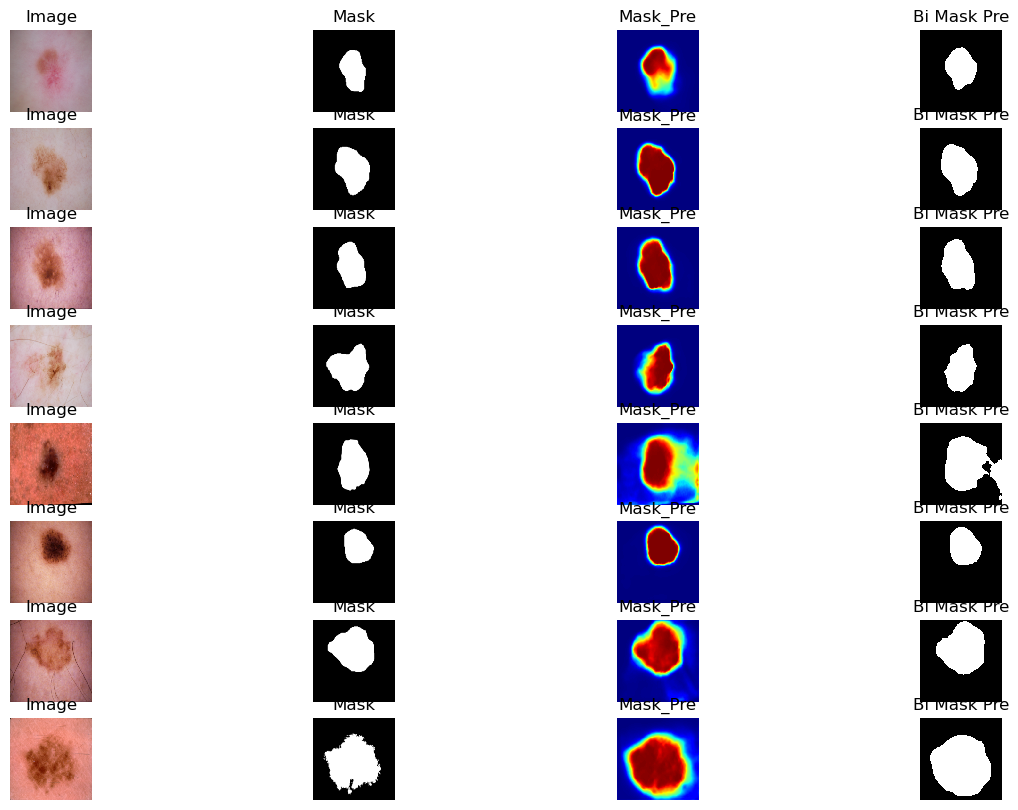

[Validation] Acc: 0.8686, SE: 0.7427, SP: 0.9421, PC: 0.7795, F1: 0.7144, JS: 0.6126, DC: 0.7144, unet_score: 1.3270
TRAIN [44100/6200000]  BCE Loss: 0.0859 LR: 5.656e-05 
TRAIN [44200/6200000]  BCE Loss: 0.0323 LR: 5.713e-05 
TRAIN [44300/6200000]  BCE Loss: 0.1021 LR: 5.769e-05 
TRAIN [44400/6200000]  BCE Loss: 0.0460 LR: 5.826e-05 
TRAIN [44500/6200000]  BCE Loss: 0.0319 LR: 5.883e-05 
TRAIN [44600/6200000]  BCE Loss: 0.0970 LR: 5.939e-05 
TRAIN [44700/6200000]  BCE Loss: 0.0093 LR: 5.996e-05 
TRAIN [44800/6200000]  BCE Loss: 0.1926 LR: 6.053e-05 
TRAIN [44900/6200000]  BCE Loss: 0.0455 LR: 6.109e-05 
TRAIN [45000/6200000]  BCE Loss: 0.0049 LR: 6.166e-05 
TRAIN [45100/6200000]  BCE Loss: 0.0432 LR: 6.223e-05 
TRAIN [45200/6200000]  BCE Loss: 0.0197 LR: 6.279e-05 
TRAIN [45300/6200000]  BCE Loss: 0.0221 LR: 6.336e-05 
TRAIN [45400/6200000]  BCE Loss: 0.0172 LR: 6.393e-05 
TRAIN [45500/6200000]  BCE Loss: 0.1286 LR: 6.449e-05 
TRAIN [45600/6200000]  BCE Loss: 0.0417 LR: 6.506e-05 
TRA

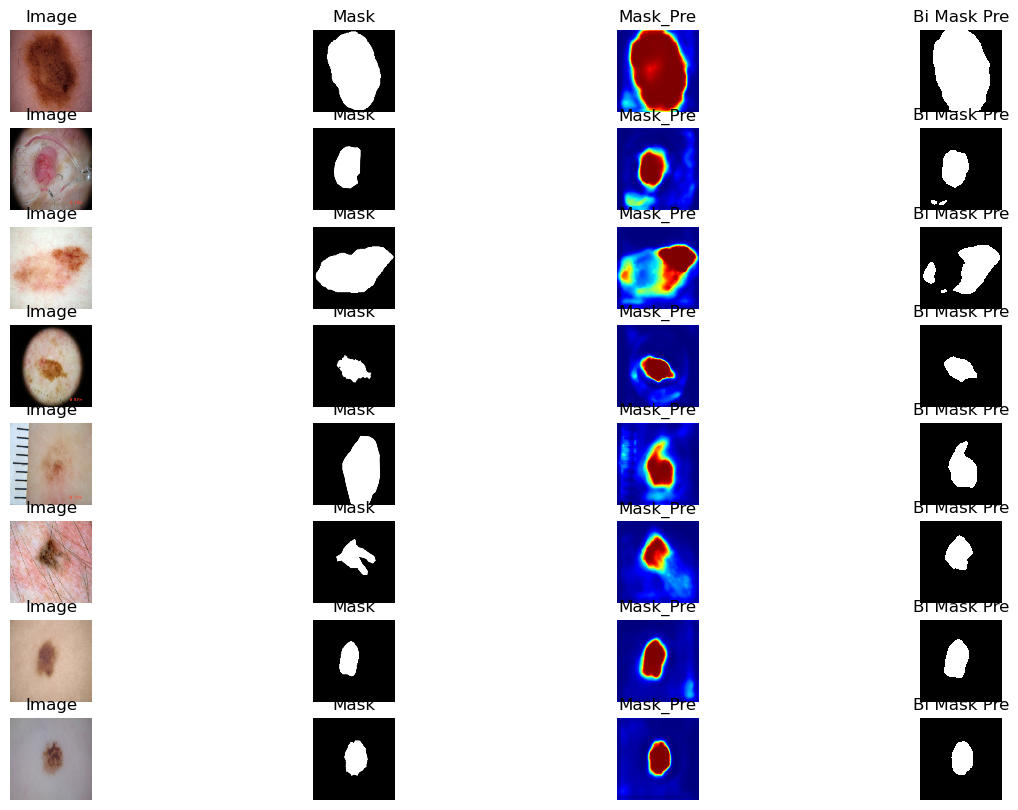

[Validation] Acc: 0.8738, SE: 0.8491, SP: 0.9120, PC: 0.7599, F1: 0.7609, JS: 0.6581, DC: 0.7609, unet_score: 1.4190
TRAIN [46700/6200000]  BCE Loss: 0.0974 LR: 7.129e-05 
TRAIN [46800/6200000]  BCE Loss: 0.0180 LR: 7.186e-05 
TRAIN [46900/6200000]  BCE Loss: 0.0230 LR: 7.243e-05 
TRAIN [47000/6200000]  BCE Loss: 0.2209 LR: 7.299e-05 
TRAIN [47100/6200000]  BCE Loss: 0.0838 LR: 7.356e-05 
TRAIN [47200/6200000]  BCE Loss: 0.0272 LR: 7.413e-05 
TRAIN [47300/6200000]  BCE Loss: 0.0791 LR: 7.469e-05 
TRAIN [47400/6200000]  BCE Loss: 0.0816 LR: 7.526e-05 
TRAIN [47500/6200000]  BCE Loss: 0.0150 LR: 7.583e-05 
TRAIN [47600/6200000]  BCE Loss: 0.1145 LR: 7.639e-05 
TRAIN [47700/6200000]  BCE Loss: 0.7488 LR: 7.696e-05 
TRAIN [47800/6200000]  BCE Loss: 0.0311 LR: 7.753e-05 
TRAIN [47900/6200000]  BCE Loss: 0.0110 LR: 7.809e-05 
TRAIN [48000/6200000]  BCE Loss: 0.1236 LR: 7.866e-05 
TRAIN [48100/6200000]  BCE Loss: 0.0210 LR: 7.923e-05 
TRAIN [48200/6200000]  BCE Loss: 0.0055 LR: 7.979e-05 
TRA

In [ ]:
if __name__ == '__main__':

#     parser = argparse.ArgumentParser(description='Recurent Residual Attention Unet Implementation')
#     parser.add_argument('--yaml_config', type=str, default='config.yaml')
#     args = parser.parse_args()


#     cfg = yaml.load(open(args.yaml_config,'r'), Loader=yaml.FullLoader)
    main(cfg)